## This is Owen Monroe's Notebook for the IS 567 Text Mining Final Project - Topres and Hand Annotation Comparison
This notebook evaluates NER models and tagging, comparing the topres historical NER model to my own hand-annotated data. The "topres" model was found on huggingface and is trained on historical english language newspapers. The text data comes from downloaded files from the Hathi-Trust Digital Library. These texts are 19th Century Magazines from the publishers, The Society for the Diffusion of Useful Knowledge, the William and Robert Chambers, and the Society for the Diffusion of Christian and General Knowledge among the Chinese. 

In [1]:
pip install -U flair

Note: you may need to restart the kernel to use updated packages.


In [2]:
from flair.models import SequenceTagger
from flair.data import Sentence


/Users/owenmonroe/anaconda3/envs/textmining/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loading the Tagger Model 

tagger = SequenceTagger.load("hmbert/flair-hipe-2022-topres19th-en")

2023-12-05 17:34:47,096 SequenceTagger predicts: Dictionary with 13 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-BUILDING, B-BUILDING, E-BUILDING, I-BUILDING, S-STREET, B-STREET, E-STREET, I-STREET


In [4]:
tag_dictionary = tagger.label_dictionary

# Get the list of all available tags
all_tags = tag_dictionary.get_items()

# Print the list of tags
print(all_tags)

['O', 'S-LOC', 'B-LOC', 'E-LOC', 'I-LOC', 'S-BUILDING', 'B-BUILDING', 'E-BUILDING', 'I-BUILDING', 'S-STREET', 'B-STREET', 'E-STREET', 'I-STREET']


In [5]:
# Creating a Function to Merge IOB tokens into a token span  

def merge_iob_tokens(annotations):
    merged_annotations = []
    current_entity = None
    current_tokens = []

    for token, label in annotations:
        iob_prefix, entity = label.split('-')
        
        if iob_prefix == 'B':
            # Start a new entity
            if current_entity:
                merged_annotations.append((' '.join(current_tokens), current_entity))
            current_entity = entity
            current_tokens = [token]
        elif iob_prefix == 'I':
            # Continue the current entity
            if current_entity == entity:
                current_tokens.append(token)
            else:
                # Start a new entity if the entity type changes
                if current_entity:
                    merged_annotations.append((' '.join(current_tokens), current_entity))
                current_entity = entity
                current_tokens = [token]

    # Append the last entity if any
    if current_entity:
        merged_annotations.append((' '.join(current_tokens), current_entity))

    return merged_annotations

In [6]:
# Creating a function to map GPE tags to LOC tags to match tags across annotation

def filter_map_tags(hand_annotations):

    tags_to_preserve = ['GPE', 'LOC']
    filtered_hand = [(token, tag) for token, tag in hand_annotations if tag in tags_to_preserve]
   
    tag_mapping = {'GPE': 'LOC'}
    hand_annotations_cleaned = [(token, tag_mapping.get(tag, tag)) for token, tag in filtered_hand]
    
    return hand_annotations_cleaned
    

In [7]:
# Cleaning the Output of the Topres Function and Creating a List of Token, Tag, Tuples

def get_token_tag_tuples(text):
    text_str = str(text)
    # Split the sentence based on the arrow (→)
    parts = text_str.split('→')
    if len(parts) == 2:
    # Extract the second part of the sentence and remove leading/trailing whitespace
        tags_part = parts[1].strip()
    # Split the tags_part into a list of tokens and tags
        token_tag_list = [pair.strip() for pair in tags_part.split(',')]
    # Now you have a list of token-tag pairs
    new_tuples = []
    
    for item in token_tag_list:
    # Remove the leading '["' and trailing '/LOC'
        cleaned_item = item.strip('["').strip(' \' ').strip(' \" ').strip('"]')
    
    # Split the cleaned_item by '/'
        tokens_and_label = cleaned_item.split('/')
    
        tag = tokens_and_label[1] if tokens_and_label[1] not in ('BUILDING', 'STREET') else 'LOC'
        new_tuples.append((tokens_and_label[0], tag))
        clean_tuples = [(token[:-1], tag) for token, tag in new_tuples]
        
    return clean_tuples

In [8]:
# Creating a Function to Give Reports by Label

def get_reports_by_label(pos_neg):
    tag_lists = {}

    # Organize tuples into separate lists based on tags
    for token, tag in pos_neg:
        if tag not in tag_lists:
            tag_lists[tag] = [(token, tag)]
        else:
            tag_lists[tag].append((token, tag))

    # Convert the dictionaries to lists
    lists_by_tag = list(tag_lists.values())

# Print the lists organized by tag
    for tag_list in lists_by_tag:
        print(f"{tag_list[0][1]}, {len(tag_list)} Total : ", tag_list)

## Document 1 Comparison: Clipping from Chambers's Journal 1835 (on France)

In [9]:
hand_annotated_data_1 = []
with open("Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/Chambers_InfoForPeople_France_1835.txt.tsv", "r", encoding="utf-8") as iob_file_1:
    for line in iob_file_1:
        line = line.strip()
        if line:
            token, label = line.split("\t")
           
            hand_annotated_data_1.append((token, label))

hand_annotated_tagged_1 = [(token, label) for token, label in hand_annotated_data_1 if label != 'O']

merged_hand_annotations_1 = merge_iob_tokens(hand_annotated_tagged_1)

print(f'Hand Annotations List number = {len(merged_hand_annotations_1)}')
merged_hand_annotations_1

Hand Annotations List number = 361


[('France', 'GPE'),
 ('1', 'CARDINAL'),
 ('4500', 'QUANTITY'),
 ('Jura mountains', 'LOC'),
 ('0000', 'QUANTITY'),
 ('Daaphlny', 'GPE'),
 ('Provence', 'GPE'),
 ('mountains of Auvergne', 'LOC'),
 ('Puy de Dome', 'LOC'),
 ("Moots d'Or", 'LOC'),
 ('Mont Lozcre', 'LOC'),
 ('510', 'QUANTITY'),
 ('Pyrenees', 'LOC'),
 ('France', 'GPE'),
 ('Spain', 'GPE'),
 ('Rhine', 'LOC'),
 ('Seine', 'LOC'),
 ('Loire', 'LOC'),
 ('Garonne', 'LOC'),
 ('Adour', 'LOC'),
 ('Pyrenees', 'LOC'),
 ('Bayonne', 'LOC'),
 ('Marne', 'LOC'),
 ('Oise', 'LOC'),
 ('Seine', 'LOC'),
 ('Loire', 'LOC'),
 ('Sarthe', 'LOC'),
 ('Maycnne', 'LOC'),
 ('Loire', 'LOC'),
 ('Rhone', 'LOC'),
 ('Saoue', 'LOC'),
 ('Isire', 'LOC'),
 ('Durance', 'LOC'),
 ('Ain', 'LOC'),
 ('Sorgue', 'LOC'),
 ('Tarn', 'LOC'),
 ('Dordi', 'LOC'),
 ('Garonne', 'LOC'),
 ('canals', 'FAC'),
 ('France', 'GPE'),
 ('Flanders', 'GPE'),
 ('Artuis', 'GPE'),
 ('Picardy', 'GPE'),
 ('Normandy', 'GPE'),
 ('Isle of France', 'GPE'),
 ('18 , I 70,51 > 0', 'QUANTITY'),
 ('Ga - ronne'

In [10]:
hand_annotations_filtered_1 = filter_map_tags(merged_hand_annotations_1)

print(f'Hand Annotations List Number = {len(hand_annotations_filtered_1)}')
hand_annotations_filtered_1

Hand Annotations List Number = 90


[('France', 'LOC'),
 ('Jura mountains', 'LOC'),
 ('Daaphlny', 'LOC'),
 ('Provence', 'LOC'),
 ('mountains of Auvergne', 'LOC'),
 ('Puy de Dome', 'LOC'),
 ("Moots d'Or", 'LOC'),
 ('Mont Lozcre', 'LOC'),
 ('Pyrenees', 'LOC'),
 ('France', 'LOC'),
 ('Spain', 'LOC'),
 ('Rhine', 'LOC'),
 ('Seine', 'LOC'),
 ('Loire', 'LOC'),
 ('Garonne', 'LOC'),
 ('Adour', 'LOC'),
 ('Pyrenees', 'LOC'),
 ('Bayonne', 'LOC'),
 ('Marne', 'LOC'),
 ('Oise', 'LOC'),
 ('Seine', 'LOC'),
 ('Loire', 'LOC'),
 ('Sarthe', 'LOC'),
 ('Maycnne', 'LOC'),
 ('Loire', 'LOC'),
 ('Rhone', 'LOC'),
 ('Saoue', 'LOC'),
 ('Isire', 'LOC'),
 ('Durance', 'LOC'),
 ('Ain', 'LOC'),
 ('Sorgue', 'LOC'),
 ('Tarn', 'LOC'),
 ('Dordi', 'LOC'),
 ('Garonne', 'LOC'),
 ('France', 'LOC'),
 ('Flanders', 'LOC'),
 ('Artuis', 'LOC'),
 ('Picardy', 'LOC'),
 ('Normandy', 'LOC'),
 ('Isle of France', 'LOC'),
 ('Ga - ronne', 'LOC'),
 ('Languedoc', 'LOC'),
 ('Limarne', 'LOC'),
 ('Auvergne', 'LOC'),
 ('provinces', 'LOC'),
 ('Bretagne', 'LOC'),
 ('Anjou', 'LOC'),
 ('

In [11]:
with open("Useful_Knowledge_Texts/Clipped_Texts/Chambers_InfoForPeople_France_1835.txt", "r", encoding="utf-8") as text_file_1:
    text_1 = text_file_1.read()

sentenced_1 = Sentence(text_1)
tagger.predict(sentenced_1)

sentenced_1

Sentence[2851]: "he principal mountains of France are, 1. The   Toeget on the north-east. They are of a rounded oat-   Bne, with gentle slopes, and afford much open paa-   turage. The highest summit is not more than 4500   ftet nigh. 2. The Jura mountains He to the south of   these, and their summiu rise to the height of 0000   feet. 3. Many Alpine branches intersect Daaphlny   and Provence. In the ceotre of the kingdom are, 4.   The mountains of Auvergne, of volcamo origin, of   which the Puy de Dome, the Moots d'Or, and the   Cental, are the principal groups. 5. The Cerennee   Be to the south-east of the range last mentioned.   Their highest summit Is Mont Lozcre (about C510   Ihet). 0. The Pyrenees form the prlnnipai part of the   boundary between France and Spain. These moun-   tains divide the cou.utry into four great basins, the   form and exposure of which necessarily have a great   influence on their climate and productions. The nar-   row valley of the Rhine runs from nortli t

In [12]:
topres_annotations_1 = get_token_tag_tuples(sentenced_1)
print(f'Topres Annotations List Number = {len(topres_annotations_1)}')
topres_annotations_1

Topres Annotations List Number = 103


[('France', 'LOC'),
 ('Toeget', 'LOC'),
 ('Jura', 'LOC'),
 ('Daaphlny', 'LOC'),
 ('Provence', 'LOC'),
 ('Auvergne', 'LOC'),
 ('Puy de Dome', 'LOC'),
 ("Moots d'Or", 'LOC'),
 ('Cental', 'LOC'),
 ('Mont Lozcre', 'LOC'),
 ('Pyrenees', 'LOC'),
 ('France', 'LOC'),
 ('Spain', 'LOC'),
 ('Rhine', 'LOC'),
 ('<', 'LOC'),
 ('Seine', 'LOC'),
 ('Loire', 'LOC'),
 ('Garonne', 'LOC'),
 ('Adour', 'LOC'),
 ('Pyrenees', 'LOC'),
 ('Bayonne', 'LOC'),
 ('Marne', 'LOC'),
 ('Oise', 'LOC'),
 ('Seine', 'LOC'),
 ('Allier', 'LOC'),
 ('Loire', 'LOC'),
 ('Sarthe', 'LOC'),
 ('Maycnne', 'LOC'),
 ('Loire', 'LOC'),
 ('Rhone', 'LOC'),
 ('Saoue', 'LOC'),
 ('Isire', 'LOC'),
 ('Durance', 'LOC'),
 ('Ain', 'LOC'),
 ('Sorgue', 'LOC'),
 ('Tarn', 'LOC'),
 ('Dordi^e', 'LOC'),
 ('Garonne', 'LOC'),
 ('France', 'LOC'),
 ('Flanders', 'LOC'),
 ('Artuis', 'LOC'),
 ('Picardy', 'LOC'),
 ('Normandy', 'LOC'),
 ('Isle   of France', 'LOC'),
 ('Ga', 'LOC'),
 ('ronne', 'LOC'),
 ('Languedoc', 'LOC'),
 ('Limarne', 'LOC'),
 ('Auvergne', 'LOC'),


Doc 1 (Chambers's Information for the People 1835) EVALUATION REPORTS : HAND AND TOPRES NER ANNOTATION SUBSETS

Micro PRECISION score for subsets = 1.0
Weighted PRECISION score for subsets = 1.0

Micro RECALL score for subsets = 1.0
Weighted RECALL score for subsets = 1.0

Micro F1 score for subsets = 1.0
Weighted F1 score for subsets = 1.0

Individual label performance: 
Accuracy score:  1.0
              precision    recall  f1-score   support

         LOC       1.00      1.00      1.00        90

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



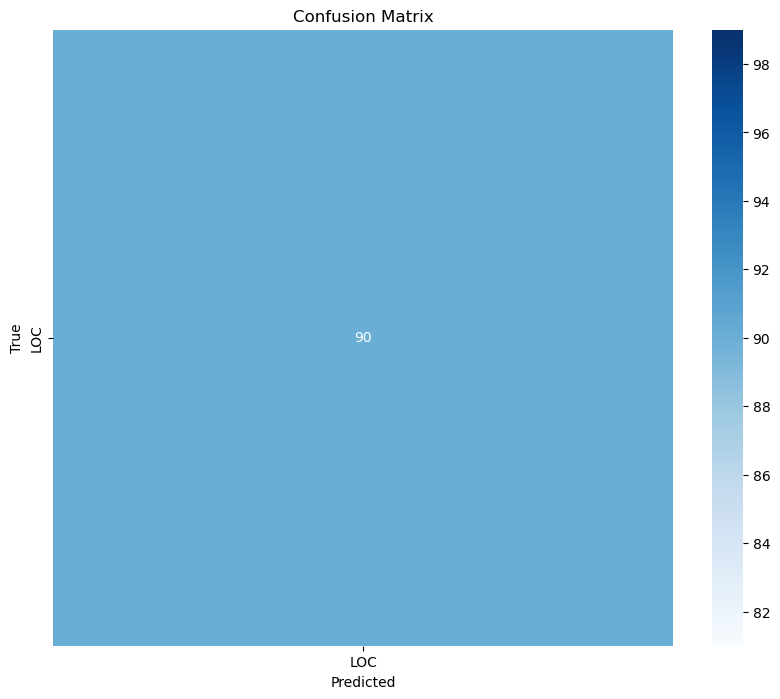

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


hand_subset_1 = hand_annotations_filtered_1[:90]
topres_subset_1 = topres_annotations_1[:90]

y_true_1 = [label for token, label in hand_subset_1]
y_pred_1 = [label for token, label in topres_subset_1]

prec_score_micro = precision_score(y_true_1, y_pred_1, average='micro')
prec_score_weighted = precision_score(y_true_1, y_pred_1, average='weighted')

rec_score_micro = recall_score(y_true_1, y_pred_1, average='micro')
rec_score_weighted = recall_score(y_true_1, y_pred_1, average='weighted')

f1_score_micro = f1_score(y_true_1, y_pred_1, average='micro')
f1_score_weighted = f1_score(y_true_1, y_pred_1, average='weighted')

print("Doc 1 (Chambers's Information for the People 1835) EVALUATION REPORTS : HAND AND TOPRES NER ANNOTATION SUBSETS")
print()
print(f'Micro PRECISION score for subsets = {prec_score_micro}')
print(f'Weighted PRECISION score for subsets = {prec_score_weighted}')
print()
print(f'Micro RECALL score for subsets = {rec_score_micro}')
print(f'Weighted RECALL score for subsets = {rec_score_weighted}')
print()
print(f'Micro F1 score for subsets = {f1_score_micro}')
print(f'Weighted F1 score for subsets = {f1_score_weighted}')
print()
print ("Individual label performance: ")
print ("Accuracy score: ", accuracy_score(y_true_1, y_pred_1))
print (classification_report(y_true_1, y_pred_1))



labels = sorted(list(set(y_true_1 + y_pred_1)))

conf_matrix = confusion_matrix(y_true_1, y_pred_1, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
ground_truth_set = set(hand_annotations_filtered_1)
hist_ner_predictions_set = set(topres_annotations_1)

true_positives = ground_truth_set.intersection(hist_ner_predictions_set)

num_true_positives = len(true_positives)
print('True Positives are when hand truth matches topres model predictions')
print(f"Number of True Positives: {num_true_positives} for Document 1 - Chambers's Information for the people 1835")
print()

print('False Positives By Label:')
get_reports_by_label(true_positives)
print()
print('Total False Positives:')

for entity in true_positives:
    print(f"True Positive: {entity}")

True Positives are when hand truth matches topres model predictions
Number of True Positives: 50 for Document 1 - Chambers's Information for the people 1835

False Positives By Label:
LOC, 50 Total :  [('Marne', 'LOC'), ('Rhine', 'LOC'), ('Limarne', 'LOC'), ('Bordeaux', 'LOC'), ('Pyrenees', 'LOC'), ('Cambray', 'LOC'), ('Provence', 'LOC'), ('Alsace', 'LOC'), ('Ardennes', 'LOC'), ('Oise', 'LOC'), ('Lyons', 'LOC'), ('Flanders', 'LOC'), ('Seine', 'LOC'), ('Loire', 'LOC'), ('Tarn', 'LOC'), ('Languedoc', 'LOC'), ('Sorgue', 'LOC'), ('Puy de Dome', 'LOC'), ('Bayonne', 'LOC'), ('Cevennes', 'LOC'), ('Artuis', 'LOC'), ('Mediterranean', 'LOC'), ('Sedan', 'LOC'), ('France', 'LOC'), ("Moots d'Or", 'LOC'), ('England', 'LOC'), ('St Quentin', 'LOC'), ('Anjou', 'LOC'), ('Bretagne', 'LOC'), ('Garonne', 'LOC'), ('Mont Lozcre', 'LOC'), ('Adour', 'LOC'), ('Picardy', 'LOC'), ('Ain', 'LOC'), ('Maycnne', 'LOC'), ('Durance', 'LOC'), ('Daaphlny', 'LOC'), ('Sarthe', 'LOC'), ('Spain', 'LOC'), ('Ganges', 'LOC'), ('

In [15]:
false_negatives = ground_truth_set.difference(hist_ner_predictions_set)

num_false_negatives = len(false_negatives)
print('False Negatives are present in hand truth but not topres model predictions')
print(f"Number of False Negatives: {num_false_negatives} in Document 1 - Chambers's Information for the People 1835")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives)
print()
print('Total False Negatives:')

for entity in false_negatives:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not topres model predictions
Number of False Negatives: 10 in Document 1 - Chambers's Information for the People 1835

False Negatives By Label:
LOC, 10 Total :  [('colonies', 'LOC'), ('Ga - ronne', 'LOC'), ('southern provinces', 'LOC'), ('provinces', 'LOC'), ("For . taincl'leau", 'LOC'), ('Jura mountains', 'LOC'), ('Isle of France', 'LOC'), ('Valen - ciennes', 'LOC'), ('Dordi', 'LOC'), ('mountains of Auvergne', 'LOC')]

Total False Negatives:
False Negative : ('colonies', 'LOC')
False Negative : ('Ga - ronne', 'LOC')
False Negative : ('southern provinces', 'LOC')
False Negative : ('provinces', 'LOC')
False Negative : ("For . taincl'leau", 'LOC')
False Negative : ('Jura mountains', 'LOC')
False Negative : ('Isle of France', 'LOC')
False Negative : ('Valen - ciennes', 'LOC')
False Negative : ('Dordi', 'LOC')
False Negative : ('mountains of Auvergne', 'LOC')


In [16]:
false_positives = hist_ner_predictions_set.difference(ground_truth_set)

num_false_positives = len(false_positives)
print('False Positives are predicted by spacy but are not in hand truth')
print(f"Number of False Positives: {num_false_positives} in Document 1 - Chambers's Information for the People 1835")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives)
print()
print('Total False Positives:')

for entity in false_positives:
    print(f"False Positive : {entity}")

False Positives are predicted by spacy but are not in hand truth
Number of False Positives: 18 in Document 1 - Chambers's Information for the People 1835

False Positives By Label:
LOC, 18 Total :  [('Allier', 'LOC'), ('Burgundy', 'LOC'), ('Ga', 'LOC'), ('Louvain', 'LOC'), ('Isle   of France', 'LOC'), ('Jura', 'LOC'), ('ronne', 'LOC'), ('Champagne', 'LOC'), ('Toeget', 'LOC'), ('ciennes', 'LOC'), ("For.taincl'leau", 'LOC'), ('Artois', 'LOC'), ('Cental', 'LOC'), ('Dordi^e', 'LOC'), ('Claret', 'LOC'), ('<', 'LOC'), ('Valen', 'LOC'), ('Hermitage', 'LOC')]

Total False Positives:
False Positive : ('Allier', 'LOC')
False Positive : ('Burgundy', 'LOC')
False Positive : ('Ga', 'LOC')
False Positive : ('Louvain', 'LOC')
False Positive : ('Isle   of France', 'LOC')
False Positive : ('Jura', 'LOC')
False Positive : ('ronne', 'LOC')
False Positive : ('Champagne', 'LOC')
False Positive : ('Toeget', 'LOC')
False Positive : ('ciennes', 'LOC')
False Positive : ("For.taincl'leau", 'LOC')
False Positive

In [17]:
rec_calc = num_true_positives / (num_true_positives + num_false_negatives)
prec_calc = num_true_positives / (num_true_positives + num_false_positives)
f1_calc = (2 * prec_calc * rec_calc) / (prec_calc + rec_calc)

print("Evaluation Calculation Reports for Document 1 - Chambers's Information for the People 1835")
print()
print(f'Recall Score = {rec_calc}')
print(f'Precision Score = {prec_calc}')
print(f'F1 Score = {f1_calc}')

Evaluation Calculation Reports for Document 1 - Chambers's Information for the People 1835

Recall Score = 0.8333333333333334
Precision Score = 0.7352941176470589
F1 Score = 0.78125


This Evaluation Technique does not work for when there is a very limited number of data and they all have the same  label.
Tokens are different, but tags are the same, resulting in perfect prediction.... 

This technique might work for data where "Nulls" or untagged tokens labeled as 'O' are preserved in the data set...


## Document 2 Comparison: Clipping from Chambers's Journal 1839 (on Literature)


In [18]:
hand_annotated_data_2 = []
with open("Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/Chambers_Journal_literature_Jan26_1839.txt.tsv", "r", encoding="utf-8") as iob_file_2:
    for line in iob_file_2:
        line = line.strip()
        if line:
            token, label = line.split("\t")
           
            hand_annotated_data_2.append((token, label))

hand_annotated_tagged_2 = [(token, label) for token, label in hand_annotated_data_2 if label != 'O']

merged_hand_annotations_2 = merge_iob_tokens(hand_annotated_tagged_2)

print(f'Hand Annotations List number = {len(merged_hand_annotations_2)}')
merged_hand_annotations_2

Hand Annotations List number = 187


[('EDINBURGIT', 'GPE'),
 ('CHAMBERS', 'PERSON'),
 ('WILLIAM', 'PERSON'),
 ('ROBERT CHAMBERS', 'PERSON'),
 ('CHAMBERS', 'PERSON'),
 ('BRADBURY', 'PERSON'),
 ('EVANS', 'PERSON'),
 ('WHITEFRIARS', 'GPE'),
 ('SATURDAY , JANUARY 26 , 1839', 'DATE'),
 ('THREE HALFPENSE', 'MONEY'),
 ('meat', 'PRODUCT'),
 ('Crusoe', 'WORK_OF_ART'),
 ('Gulliver', 'WORK_OF_ART'),
 ('Waverley Novels', 'WORK_OF_ART'),
 ('Fielding', 'PERSON'),
 ('Smollett', 'PERSON'),
 ('Parson Adams', 'PERSON'),
 ('Lilliputians', 'ORG'),
 ('Lilliput', 'GPE'),
 ('1728', 'DATE'),
 ('Lulliputians', 'ORG'),
 ('Mr Gulliver', 'PERSON'),
 ('1728', 'DATE'),
 ('Caleb Balderstone', 'PERSON'),
 ('Dalgetty', 'PERSON'),
 ('Dominie Sampson', 'PERSON'),
 ('the novel', 'WORK_OF_ART'),
 ('Loch Katrine', 'LOC'),
 ('Fitzjames', 'PERSON'),
 ('Laputa', 'PERSON'),
 ('Rarenswood', 'LOC'),
 ('Houynhymms', 'ORG'),
 ('satires', 'WORK_OF_ART'),
 ('Partridge', 'LOC'),
 ('book', 'PRODUCT'),
 ('fiction', 'WORK_OF_ART'),
 ("Arabian Nights ' Entertainments", 'WO

In [19]:
hand_annotations_filtered_2 = filter_map_tags(merged_hand_annotations_2)

print(f'Hand Annotations List Number = {len(hand_annotations_filtered_2)}')
hand_annotations_filtered_2

Hand Annotations List Number = 40


[('EDINBURGIT', 'LOC'),
 ('WHITEFRIARS', 'LOC'),
 ('Lilliput', 'LOC'),
 ('Loch Katrine', 'LOC'),
 ('Rarenswood', 'LOC'),
 ('Partridge', 'LOC'),
 ('cottages', 'LOC'),
 ('magnetic island', 'LOC'),
 ('island', 'LOC'),
 ('island', 'LOC'),
 ('Borneo', 'LOC'),
 ('Bagdad', 'LOC'),
 ('New Zealand', 'LOC'),
 ('Pacific', 'LOC'),
 ('EDINBURGH', 'LOC'),
 ('de Coverley', 'LOC'),
 ('the inn', 'LOC'),
 ('inn', 'LOC'),
 ('Edinburgh', 'LOC'),
 ('Liddel', 'LOC'),
 ('Eloisa', 'LOC'),
 ('country', 'LOC'),
 ('England', 'LOC'),
 ('Car - else', 'LOC'),
 ('England', 'LOC'),
 ('Carwell', 'LOC'),
 ('Carwell', 'LOC'),
 ('Carwell', 'LOC'),
 ('London', 'LOC'),
 ('London', 'LOC'),
 ('Orange Bower', 'LOC'),
 ('Scotland', 'LOC'),
 ('Carwell', 'LOC'),
 ('EDINBURGH', 'LOC'),
 ('Shrewsbury', 'LOC'),
 ('Carwell', 'LOC'),
 ('Plymouth', 'LOC'),
 ('Plymouth', 'LOC'),
 ('France', 'LOC'),
 ('native land', 'LOC')]

In [20]:
with open("Useful_Knowledge_Texts/Clipped_Texts/Chambers_Journal_literature_Jan26_1839.txt", "r", encoding="utf-8") as text_file_2:
    text_2 = text_file_2.read()

sentenced_2 = Sentence(text_2)
tagger.predict(sentenced_2)

sentenced_2


Sentence[6331]: "## p. 1 (#17) ###############################################   EDINBURGIT CHAMBERS UE JO CONDUCTED BY WILLIAM AND ROBERT CHAMBERS, EDITORS OF " CHAMBERS’S INFORMATION FOR THE PEOPLE," “ CHAMBERS'S EDUCATIONAL COURSE,” &c. PRINTED BY BRADBURY AND EVANS, WHITEFRIARS, LONDON. NUMBER 365. SATURDAY, JANUARY 26, 1839. PRICE THREE HALFPENSE. WHAT ENGLISH LITERATURE GIVES US. loads of meat, for that was “ country all over.” Surely, but we can readily suppose that it must have been ENGLISH literature gives all who can enjoy it a fund in the recollection of such things we have something essentially different. The first reading of Crusoe is of pleasure, of the great amount of which we are not still better than solid philosophy. Going back a little now a feature in every man’s biography. Gulliver is apt to be quite aware till we run over a few of farther, how does the heart leap up when we recollect not so indispensable, but yet the having him is much the items. There are the Wav

In [21]:
topres_annotations_2 = get_token_tag_tuples(sentenced_2)
print(f'Topres Annotations List Number = {len(topres_annotations_2)}')
topres_annotations_2

Topres Annotations List Number = 31


[('WHITEFRIARS', 'LOC'),
 ('LONDON', 'LOC'),
 ('Stirling', 'LOC'),
 ('Katrine', 'LOC'),
 ('Wakefield', 'LOC'),
 ('Borneo', 'LOC'),
 ('Bagdad', 'LOC'),
 ('New Zealand', 'LOC'),
 ('EDINBURGH', 'LOC'),
 ('Edinburgh', 'LOC'),
 ('Border', 'LOC'),
 ('England', 'LOC'),
 ('Car- else', 'LOC'),
 ('England', 'LOC'),
 ('Milton', 'LOC'),
 ('Hudibras', 'LOC'),
 ('Surry', 'LOC'),
 ('Wyatt', 'LOC'),
 ('Carwell', 'LOC'),
 ('Carwell', 'LOC'),
 ('London', 'LOC'),
 ('London', 'LOC'),
 ('Scotland', 'LOC'),
 ('Carwell', 'LOC'),
 ('Lochryan', 'LOC'),
 ('EDINBURGH', 'LOC'),
 ('Hannah More', 'LOC'),
 ('Shrewsbury', 'LOC'),
 ('Plymouth', 'LOC'),
 ('Plymouth', 'LOC'),
 ('France', 'LOC')]

Doc 3 (Chambers's Journal 1839) EVALUATION REPORTS : HAND AND TOPRES NER ANNOTATION SUBSETS

Micro PRECISION score for subsets = 1.0
Weighted PRECISION score for subsets = 1.0

Micro RECALL score for subsets = 1.0
Weighted RECALL score for subsets = 1.0

Micro F1 score for subsets = 1.0
Weighted F1 score for subsets = 1.0

Individual label performance: 
Accuracy score:  1.0
              precision    recall  f1-score   support

         LOC       1.00      1.00      1.00        30

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



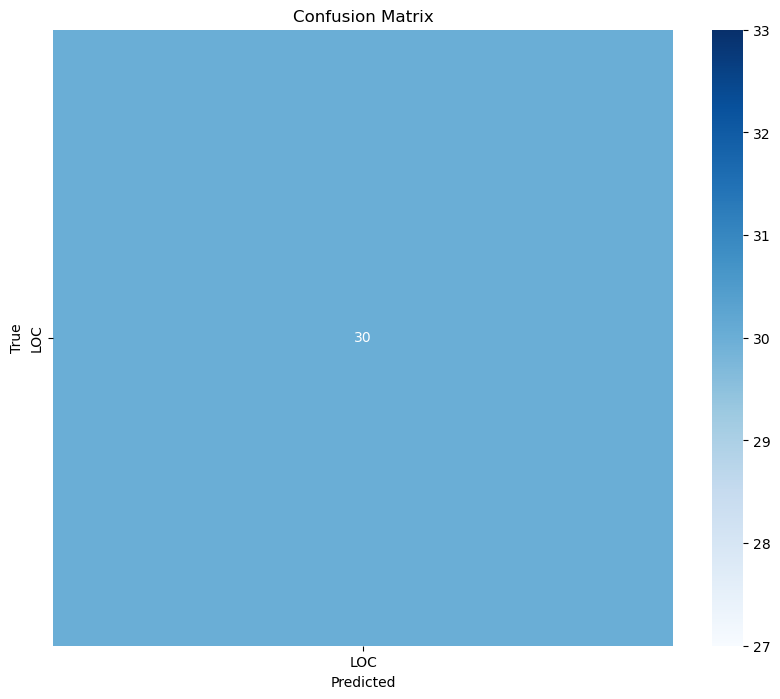

In [22]:

hand_subset_2 = hand_annotations_filtered_2[:30]
topres_subset_2 = topres_annotations_2[:30]


y_true_2 = [label for token, label in hand_subset_2]
y_pred_2 = [label for token, label in topres_subset_2]

prec_score_micro_2 = precision_score(y_true_2, y_pred_2, average='micro')
prec_score_weighted_2 = precision_score(y_true_2, y_pred_2, average='weighted')

rec_score_micro_2 = recall_score(y_true_2, y_pred_2, average='micro')
rec_score_weighted_2 = recall_score(y_true_2, y_pred_2, average='weighted')

f1_score_micro_2 = f1_score(y_true_2, y_pred_2, average='micro')
f1_score_weighted_2 = f1_score(y_true_2, y_pred_2, average='weighted')


print("Doc 3 (Chambers's Journal 1839) EVALUATION REPORTS : HAND AND TOPRES NER ANNOTATION SUBSETS")
print()
print(f'Micro PRECISION score for subsets = {prec_score_micro_2}')
print(f'Weighted PRECISION score for subsets = {prec_score_weighted_2}')
print()
print(f'Micro RECALL score for subsets = {rec_score_micro_2}')
print(f'Weighted RECALL score for subsets = {rec_score_weighted_2}')
print()
print(f'Micro F1 score for subsets = {f1_score_micro_2}')
print(f'Weighted F1 score for subsets = {f1_score_weighted_2}')
print()
print ("Individual label performance: ")
print ("Accuracy score: ", accuracy_score(y_true_2, y_pred_2))
print (classification_report(y_true_2, y_pred_2))


labels_2 = sorted(list(set(y_true_2 + y_pred_2)))

conf_matrix_2 = confusion_matrix(y_true_2, y_pred_2, labels=labels_2)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
ground_truth_set_2 = set(hand_annotations_filtered_2)
topres_predictions_set_2 = set(topres_annotations_2)

true_positives_2 = ground_truth_set_2.intersection(topres_predictions_set_2)

num_true_positives_2 = len(true_positives_2)
print('True Positives are when hand truth matches topres model predictions')
print(f"Number of True Positives: {num_true_positives_2} in Document 2 - Chambers's Journal 1839")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_2)
print()
print('Total True Positives:')

for entity in true_positives_2:
    print(f"True Positive: {entity}")

True Positives are when hand truth matches topres model predictions
Number of True Positives: 13 in Document 2 - Chambers's Journal 1839

True Positives By Label:
LOC, 13 Total :  [('Plymouth', 'LOC'), ('Bagdad', 'LOC'), ('England', 'LOC'), ('France', 'LOC'), ('EDINBURGH', 'LOC'), ('Shrewsbury', 'LOC'), ('Edinburgh', 'LOC'), ('New Zealand', 'LOC'), ('Carwell', 'LOC'), ('Scotland', 'LOC'), ('WHITEFRIARS', 'LOC'), ('Borneo', 'LOC'), ('London', 'LOC')]

Total True Positives:
True Positive: ('Plymouth', 'LOC')
True Positive: ('Bagdad', 'LOC')
True Positive: ('England', 'LOC')
True Positive: ('France', 'LOC')
True Positive: ('EDINBURGH', 'LOC')
True Positive: ('Shrewsbury', 'LOC')
True Positive: ('Edinburgh', 'LOC')
True Positive: ('New Zealand', 'LOC')
True Positive: ('Carwell', 'LOC')
True Positive: ('Scotland', 'LOC')
True Positive: ('WHITEFRIARS', 'LOC')
True Positive: ('Borneo', 'LOC')
True Positive: ('London', 'LOC')


In [24]:
false_negatives_2 = ground_truth_set_2.difference(topres_predictions_set_2)

num_false_negatives_2 = len(false_negatives_2)
print('False Negatives are present in hand truth but not topres model predictions')
print(f"Number of False Negatives: {num_false_negatives_2} in Document 2 - Chambers's Journal 1839")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_2)
print()
print('Total False Negatives:')

for entity in false_negatives_2:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not topres model predictions
Number of False Negatives: 18 in Document 2 - Chambers's Journal 1839

False Negatives By Label:
LOC, 18 Total :  [('cottages', 'LOC'), ('de Coverley', 'LOC'), ('Pacific', 'LOC'), ('Rarenswood', 'LOC'), ('native land', 'LOC'), ('magnetic island', 'LOC'), ('Car - else', 'LOC'), ('Eloisa', 'LOC'), ('EDINBURGIT', 'LOC'), ('island', 'LOC'), ('Loch Katrine', 'LOC'), ('Partridge', 'LOC'), ('inn', 'LOC'), ('the inn', 'LOC'), ('Orange Bower', 'LOC'), ('Lilliput', 'LOC'), ('Liddel', 'LOC'), ('country', 'LOC')]

Total False Negatives:
False Negative : ('cottages', 'LOC')
False Negative : ('de Coverley', 'LOC')
False Negative : ('Pacific', 'LOC')
False Negative : ('Rarenswood', 'LOC')
False Negative : ('native land', 'LOC')
False Negative : ('magnetic island', 'LOC')
False Negative : ('Car - else', 'LOC')
False Negative : ('Eloisa', 'LOC')
False Negative : ('EDINBURGIT', 'LOC')
False Negative : ('island', 'LOC')
False Nega

In [25]:
false_positives_2 = topres_predictions_set_2.difference(ground_truth_set)

num_false_positives_2 = len(false_positives_2)
print('False Positives are predicted by topres model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_2} in Document 2 - Chambers's Journal 1839")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_2)
print()
print('Total False Positives:')

for entity in false_positives_2:
    print(f"False Positive : {entity}")

False Positives are predicted by topres model but are not in hand truth
Number of False Positives: 23 in Document 2 - Chambers's Journal 1839

False Positives By Label:
LOC, 23 Total :  [('Milton', 'LOC'), ('Bagdad', 'LOC'), ('Stirling', 'LOC'), ('Lochryan', 'LOC'), ('LONDON', 'LOC'), ('Border', 'LOC'), ('WHITEFRIARS', 'LOC'), ('Hudibras', 'LOC'), ('New Zealand', 'LOC'), ('Katrine', 'LOC'), ('Borneo', 'LOC'), ('Wakefield', 'LOC'), ('Plymouth', 'LOC'), ('Hannah More', 'LOC'), ('Edinburgh', 'LOC'), ('Wyatt', 'LOC'), ('Carwell', 'LOC'), ('Car- else', 'LOC'), ('EDINBURGH', 'LOC'), ('Shrewsbury', 'LOC'), ('Surry', 'LOC'), ('Scotland', 'LOC'), ('London', 'LOC')]

Total False Positives:
False Positive : ('Milton', 'LOC')
False Positive : ('Bagdad', 'LOC')
False Positive : ('Stirling', 'LOC')
False Positive : ('Lochryan', 'LOC')
False Positive : ('LONDON', 'LOC')
False Positive : ('Border', 'LOC')
False Positive : ('WHITEFRIARS', 'LOC')
False Positive : ('Hudibras', 'LOC')
False Positive : ('N

In [26]:
rec_calc_2 = num_true_positives_2 / (num_true_positives_2 + num_false_negatives_2)
prec_calc_2 = num_true_positives_2 / (num_true_positives_2 + num_false_positives_2)
f1_calc_2 = (2 * prec_calc_2 * rec_calc_2) / (prec_calc_2 + rec_calc_2)

print("Evaluation Calculation Reports for Document 2 - Chambers's Journal 1839")
print()
print(f'Recall Score = {rec_calc_2}')
print(f'Precision Score = {prec_calc_2}')
print(f'F1 Score = {f1_calc_2}')

Evaluation Calculation Reports for Document 2 - Chambers's Journal 1839

Recall Score = 0.41935483870967744
Precision Score = 0.3611111111111111
F1 Score = 0.3880597014925373


## Document 3 Comparison: Clipping from Chambers's Journal 1851 (on Monasteries)

In [27]:
# Loading and Cleaning Data for Document 3
hand_annotated_data_3 = []
with open("Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/Chambers_Journal_monastery_1851.txt.tsv", "r", encoding="utf-8") as iob_file_3:
    for line in iob_file_3:
        line = line.strip()
        if line:
            token, label = line.split("\t")
           
            hand_annotated_data_3.append((token, label))

hand_annotated_tagged_3 = [(token, label) for token, label in hand_annotated_data_3 if label != 'O']

merged_hand_annotations_3 = merge_iob_tokens(hand_annotated_tagged_3)
hand_annotations_filtered_3 = filter_map_tags(merged_hand_annotations_3)

print(f'Hand Annotations List Number = {len(hand_annotations_filtered_3)}')
hand_annotations_filtered_3


Hand Annotations List Number = 14


[('England', 'LOC'),
 ('Gate - house', 'LOC'),
 ('Guest - Hall', 'LOC'),
 ('Benedictine convent', 'LOC'),
 ('Ham', 'LOC'),
 ('Leicestershire', 'LOC'),
 ('county', 'LOC'),
 ('place of abode', 'LOC'),
 ('England', 'LOC'),
 ('county', 'LOC'),
 ('EDINBURGH', 'LOC'),
 ('England', 'LOC'),
 ('land of dreams', 'LOC'),
 ('apartment', 'LOC')]

In [28]:
with open("Useful_Knowledge_Texts/Clipped_Texts/Chambers_Journal_monastery_1851.txt", "r", encoding="utf-8") as text_file_3:
    text_3 = text_file_3.read()

sentenced_3 = Sentence(text_3)
tagger.predict(sentenced_3)

sentenced_3

Sentence[2167]: "VISIT TO AN ENGLISH MONASTERY. I HAVE always felt a deep interest in monks and monkery, and an interest that did not commence with my historical period, but may be traced far back in the fabulous Radcliffian era. I knew of course that there I was received by a venerable-looking monk, in a were monks in England, but could never believe them light drab habit reaching to his ankles, who with to be anything more than imitation monks. An Italian much kindness of manner bade me welcome. He con- or a Spanish monk I could understand, and, spite of ducted me to an inner room of the Gate-house, where I the chronic revolution now going on, I had not alto-wrote my name in the visitors' book; and we then gether withdrawn my faith from a French monk. But crossed a quadrangular court to the Guest-Hall, where an English monk seemed highly improbable. I was tea and other refreshments had been prepared. While once invited to visit the Benedictine convent at Ham-gazing round me like a ma

In [29]:
topres_annotations_3 = get_token_tag_tuples(sentenced_3)
print(f'Topres Annotations List Number = {len(topres_annotations_3)}')
topres_annotations_3

Topres Annotations List Number = 11


[('England', 'LOC'),
 ('Gate-house', 'LOC'),
 ('Guest-Hall', 'LOC'),
 ('Benedictine', 'LOC'),
 ('Ham-gazing', 'LOC'),
 ('Mount St Bernard', 'LOC'),
 ('Leicestershire', 'LOC'),
 ('St Bernard', 'LOC'),
 ('England', 'LOC'),
 ('EDINBURGH', 'LOC'),
 ('England', 'LOC')]

In [30]:
ground_truth_set_3 = set(hand_annotations_filtered_3)
topres_predictions_set_3 = set(topres_annotations_3)

true_positives_3 = ground_truth_set_3.intersection(topres_predictions_set_3)

num_true_positives_3 = len(true_positives_3)
print('True Positives are when hand truth matches topres model predictions')
print(f"Number of True Positives: {num_true_positives_3} in Document 3 - Chambers's Journal 1851")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_3)
print()
print('Total True Positives:')

for entity in true_positives_3:
    print(f"True Positive : {entity}")

True Positives are when hand truth matches topres model predictions
Number of True Positives: 3 in Document 3 - Chambers's Journal 1851

True Positives By Label:
LOC, 3 Total :  [('Leicestershire', 'LOC'), ('England', 'LOC'), ('EDINBURGH', 'LOC')]

Total True Positives:
True Positive : ('Leicestershire', 'LOC')
True Positive : ('England', 'LOC')
True Positive : ('EDINBURGH', 'LOC')


In [31]:
false_negatives_3 = ground_truth_set_3.difference(topres_predictions_set_3)

num_false_negatives_3 = len(false_negatives_3)
print('False Negatives are present in hand truth but not topres model predictions')
print(f"Number of False Negatives: {num_false_negatives_3} in Document 3 - Chambers's Journal 1851")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_3)
print()
print('Total False Negatives:')

for entity in false_negatives_3:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not topres model predictions
Number of False Negatives: 8 in Document 3 - Chambers's Journal 1851

False Negatives By Label:
LOC, 8 Total :  [('Gate - house', 'LOC'), ('place of abode', 'LOC'), ('county', 'LOC'), ('Guest - Hall', 'LOC'), ('apartment', 'LOC'), ('Ham', 'LOC'), ('land of dreams', 'LOC'), ('Benedictine convent', 'LOC')]

Total False Negatives:
False Negative : ('Gate - house', 'LOC')
False Negative : ('place of abode', 'LOC')
False Negative : ('county', 'LOC')
False Negative : ('Guest - Hall', 'LOC')
False Negative : ('apartment', 'LOC')
False Negative : ('Ham', 'LOC')
False Negative : ('land of dreams', 'LOC')
False Negative : ('Benedictine convent', 'LOC')


In [32]:
false_positives_3 = topres_predictions_set_3.difference(ground_truth_set_3)

num_false_positives_3 = len(false_positives_3)
print('False Positives are predicted by topres model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_3} in Document 3 - Chambers's Journal 1851")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_3)
print()
print('Total False Positives:')

for entity in false_positives_3:
    print(f"False Positive : {entity}")

False Positives are predicted by topres model but are not in hand truth
Number of False Positives: 6 in Document 3 - Chambers's Journal 1851

False Positives By Label:
LOC, 6 Total :  [('Ham-gazing', 'LOC'), ('Mount St Bernard', 'LOC'), ('Gate-house', 'LOC'), ('Guest-Hall', 'LOC'), ('Benedictine', 'LOC'), ('St Bernard', 'LOC')]

Total False Positives:
False Positive : ('Ham-gazing', 'LOC')
False Positive : ('Mount St Bernard', 'LOC')
False Positive : ('Gate-house', 'LOC')
False Positive : ('Guest-Hall', 'LOC')
False Positive : ('Benedictine', 'LOC')
False Positive : ('St Bernard', 'LOC')


In [33]:
rec_calc_3 = num_true_positives_3 / (num_true_positives_3 + num_false_negatives_3)
prec_calc_3 = num_true_positives_3 / (num_true_positives_3 + num_false_positives_3)
f1_calc_3 = (2 * prec_calc_3 * rec_calc_3) / (prec_calc_3 + rec_calc_3)

print("Evaluation Calculation Reports for Document 3 Chambers's Journal 1851")
print()
print(f'Recall Score = {rec_calc_3}')
print(f'Precision Score = {prec_calc_3}')
print(f'F1 Score = {f1_calc_3}')

Evaluation Calculation Reports for Document 3 Chambers's Journal 1851

Recall Score = 0.2727272727272727
Precision Score = 0.3333333333333333
F1 Score = 0.3


## Document 4 Comparison: Clipping from Chambers's Journal 1872 (on Sorrow)

In [34]:
# Loading and Cleaning Data for Document 4
hand_annotated_data_4 = []
with open("Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/Chambers_Journal_sorrow_Jan6_1872.txt.tsv", "r", encoding="utf-8") as iob_file_4:
    for line in iob_file_4:
        line = line.strip()
        if line:
            token, label = line.split("\t")
           
            hand_annotated_data_4.append((token, label))

hand_annotated_tagged_4 = [(token, label) for token, label in hand_annotated_data_4 if label != 'O']

merged_hand_annotations_4 = merge_iob_tokens(hand_annotated_tagged_4)
hand_annotations_filtered_4 = filter_map_tags(merged_hand_annotations_4)

print(f'Hand Annotations List Number = {len(hand_annotations_filtered_4)}')
hand_annotations_filtered_4

Hand Annotations List Number = 11


[('Cres - cent House', 'LOC'),
 ('Hampstead', 'LOC'),
 ('Crescent House', 'LOC'),
 ('Crest House', 'LOC'),
 ('Miriam', 'LOC'),
 ('Walter', 'LOC'),
 ('Miriam', 'LOC'),
 ('Miss Monitor', 'LOC'),
 ('Crescent House', 'LOC'),
 ('country', 'LOC'),
 ('country', 'LOC')]

In [35]:
with open("Useful_Knowledge_Texts/Clipped_Texts/Chambers_Journal_sorrow_Jan6_1872.txt", "r", encoding="utf-8") as text_file_4:
    text_4 = text_file_4.read()

sentenced_4 = Sentence(text_4)
tagger.predict(sentenced_4)

sentenced_4

Sentence[2192]: "## p. 1 (#11) ###############################################  CHAMBERS'S JOURNAL LITERATURE, SCIENCE, AND ART Fourth Sexiez CONDUCTED BY WILLIAM AND ROBERT No. 419. OF POPULAR SATURDAY, JANUARY 6, 1872. A GOLDEN CHAMBERS. CHAPTER I.-CANDIDATES. MIRIAM CLINT was about to leave school. She was not glad of it. She was eighteen years old, and had her notions and her visions about 'coming out,' like other girls of her age, and especially of her appearance. The time to which these notions would naturally have tended, and these visions soared, was at hand, and yet Miriam Clint was not glad of it. This is a paradox which requires explanation. Miriam had every reason to believe that her visions would remain entirely unfulfilled; she had good cause to like the school at which she had passed eight years, in tolerable comfort to herself, and harmony with her surroundings; and she had no cause whatever to like home, or to anticipate that it would be more endurable when she should 

In [36]:
topres_annotations_4 = get_token_tag_tuples(sentenced_4)
print(f'Topres Annotations List Number = {len(topres_annotations_4)}')
topres_annotations_4

Topres Annotations List Number = 6


[('Cres- cent House', 'LOC'),
 ('Hampstead', 'LOC'),
 ('Crescent House', 'LOC'),
 ('Crest House', 'LOC'),
 ('Lond. Bge', 'LOC'),
 ('Crescent House', 'LOC')]

In [37]:
ground_truth_set_4 = set(hand_annotations_filtered_4)
topres_predictions_set_4 = set(topres_annotations_4)

true_positives_4 = ground_truth_set_4.intersection(topres_predictions_set_4)

num_true_positives_4 = len(true_positives_4)
print('True Positives are when hand truth matches topres model predictions')
print(f"Number of True Positives: {num_true_positives_4} in Document 4 - Chambers's Journal 1872")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_4)
print()
print('Total True Positives:')

for entity in true_positives_4:
    print(f"True Positive : {entity}")

True Positives are when hand truth matches topres model predictions
Number of True Positives: 3 in Document 4 - Chambers's Journal 1872

True Positives By Label:
LOC, 3 Total :  [('Crest House', 'LOC'), ('Hampstead', 'LOC'), ('Crescent House', 'LOC')]

Total True Positives:
True Positive : ('Crest House', 'LOC')
True Positive : ('Hampstead', 'LOC')
True Positive : ('Crescent House', 'LOC')


In [38]:
false_negatives_4 = ground_truth_set_4.difference(topres_predictions_set_4)

num_false_negatives_4 = len(false_negatives_4)
print('False Negatives are present in hand truth but not topres model predictions')
print(f"Number of False Negatives: {num_false_negatives_4} in Document 4 - Chambers's Journal 1872")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_4)
print()
print('Total False Negatives:')

for entity in false_negatives_4:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not topres model predictions
Number of False Negatives: 5 in Document 4 - Chambers's Journal 1872

False Negatives By Label:
LOC, 5 Total :  [('Walter', 'LOC'), ('Miriam', 'LOC'), ('Miss Monitor', 'LOC'), ('Cres - cent House', 'LOC'), ('country', 'LOC')]

Total False Negatives:
False Negative : ('Walter', 'LOC')
False Negative : ('Miriam', 'LOC')
False Negative : ('Miss Monitor', 'LOC')
False Negative : ('Cres - cent House', 'LOC')
False Negative : ('country', 'LOC')


In [39]:
false_positives_4 = topres_predictions_set_4.difference(ground_truth_set_4)

num_false_positives_4 = len(false_positives_4)
print('False Positives are predicted by topres model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_4} in Document 4 - Chambers's Journal 1872")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_4)
print()
print('Total False Positives:')

for entity in false_positives_4:
    print(f"False Positive : {entity}")

False Positives are predicted by topres model but are not in hand truth
Number of False Positives: 2 in Document 4 - Chambers's Journal 1872

False Positives By Label:
LOC, 2 Total :  [('Lond. Bge', 'LOC'), ('Cres- cent House', 'LOC')]

Total False Positives:
False Positive : ('Lond. Bge', 'LOC')
False Positive : ('Cres- cent House', 'LOC')


In [40]:
rec_calc_4 = num_true_positives_4 / (num_true_positives_4 + num_false_negatives_4)
prec_calc_4 = num_true_positives_4 / (num_true_positives_4 + num_false_positives_4)
f1_calc_4 = (2 * prec_calc_4 * rec_calc_4) / (prec_calc_4 + rec_calc_4)

print("Evaluation Calculation Reports for Document 4 Chambers's Journal 1872")
print()
print(f'Recall Score = {rec_calc_4}')
print(f'Precision Score = {prec_calc_4}')
print(f'F1 Score = {f1_calc_4}')

Evaluation Calculation Reports for Document 4 Chambers's Journal 1872

Recall Score = 0.375
Precision Score = 0.6
F1 Score = 0.4615384615384615


## Document 5 Comparison: Clipping from SDCGK Annual Report 1888 (on their Constitution)

In [41]:
# Loading and Cleaning Hand Data for Document 5
hand_annotated_data_5 = []
with open("Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDCGK_AnnualReport_constitution_1888.txt.tsv", "r", encoding="utf-8") as iob_file_5:
    for line in iob_file_5:
        line = line.strip()
        if line:
            token, label = line.split("\t")
           
            hand_annotated_data_5.append((token, label))

hand_annotated_tagged_5 = [(token, label) for token, label in hand_annotated_data_5 if label != 'O']

merged_hand_annotations_5 = merge_iob_tokens(hand_annotated_tagged_5)
hand_annotations_filtered_5 = filter_map_tags(merged_hand_annotations_5)

print(f'Hand Annotations List Number = {len(hand_annotations_filtered_5)}')
hand_annotations_filtered_5

Hand Annotations List Number = 26


[('China', 'LOC'),
 ('Colonies', 'LOC'),
 ('Dependencies', 'LOC'),
 ('Glasgow', 'LOC'),
 ('Christian Literature Society', 'LOC'),
 ('Shanghai', 'LOC'),
 ('Capital', 'LOC'),
 ('cities', 'LOC'),
 ('18 Provinces', 'LOC'),
 ('emporiums of commerce', 'LOC'),
 ('East', 'LOC'),
 ('Hongkong', 'LOC'),
 ('Yokohama', 'LOC'),
 ('Singapore', 'LOC'),
 ('Penang', 'LOC'),
 ('Batavia', 'LOC'),
 ('China', 'LOC'),
 ('China', 'LOC'),
 ('empire', 'LOC'),
 ('China', 'LOC'),
 ('Peking', 'LOC'),
 ('Peking', 'LOC'),
 ('Mandarins', 'LOC'),
 ('empire', 'LOC'),
 ('China', 'LOC'),
 ('China', 'LOC')]

In [42]:
with open("Useful_Knowledge_Texts/Clipped_Texts/SDCGK_AnnualReport_constitution_1888.txt", "r", encoding="utf-8") as text_file_5:
    text_5 = text_file_5.read()

sentenced_5 = Sentence(text_5)
tagger.predict(sentenced_5)

sentenced_5

Sentence[1794]: " ## p. (#17) #################################################  CONSTITUTION     OF THE     Society for tbe Diffusion of Christian anO   General IRnowlehae among the Chinese.     LATE     ©HOMlEilE [MMM & YGMST §®©0ITY a *     — :o^o>-8o:-     Article I. —The Society shall be named in English the   “Society for the Diffusion of Christian and General   Knowledge among the Chinese ; ” and in the Chinese language :     (rJ % w w     Article II. Object —The object of the Society shall be,—(1)   to take over the Printing Press and other Property as a free gift   generously offered by the original promoters—the Book and Tract   Society of China; and (2) to continue the publication and circula¬   tion of literature based on Christian principles throughout China,   her Colonies, Dependencies, and wherever Chinamen are found—   especially Periodical literature adapted for all classes as the resources   of the Society may permit.     Article III. Mode of Operation .—These object

In [43]:
topres_annotations_5 = get_token_tag_tuples(sentenced_5)
print(f'Topres Annotations List Number = {len(topres_annotations_5)}')
topres_annotations_5

Topres Annotations List Number = 18


[('China', 'LOC'),
 ('China', 'LOC'),
 ('Chinamen', 'LOC'),
 ('China', 'LOC'),
 ('Glasgow', 'LOC'),
 ('Shanghai', 'LOC'),
 ('Hongkong', 'LOC'),
 ('Yokohama', 'LOC'),
 ('Singapore', 'LOC'),
 ('Penang', 'LOC'),
 ('Batavia', 'LOC'),
 ('China', 'LOC'),
 ('China', 'LOC'),
 ('China', 'LOC'),
 ('Peking', 'LOC'),
 ('Peking', 'LOC'),
 ('China', 'LOC'),
 ('China', 'LOC')]

In [44]:
ground_truth_set_5 = set(hand_annotations_filtered_5)
topres_predictions_set_5 = set(topres_annotations_5)

true_positives_5 = ground_truth_set_5.intersection(topres_predictions_set_5)

num_true_positives_5 = len(true_positives_5)
print('True Positives are when hand truth matches topres model predictions')
print(f"Number of True Positives: {num_true_positives_5} in Document 5 - SDCGK Annual Report 1888")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_5)
print()
print('Total True Positives:')

for entity in true_positives_5:
    print(f"True Positive : {entity}")

True Positives are when hand truth matches topres model predictions
Number of True Positives: 9 in Document 5 - SDCGK Annual Report 1888

True Positives By Label:
LOC, 9 Total :  [('Yokohama', 'LOC'), ('Hongkong', 'LOC'), ('Singapore', 'LOC'), ('Penang', 'LOC'), ('China', 'LOC'), ('Batavia', 'LOC'), ('Glasgow', 'LOC'), ('Peking', 'LOC'), ('Shanghai', 'LOC')]

Total True Positives:
True Positive : ('Yokohama', 'LOC')
True Positive : ('Hongkong', 'LOC')
True Positive : ('Singapore', 'LOC')
True Positive : ('Penang', 'LOC')
True Positive : ('China', 'LOC')
True Positive : ('Batavia', 'LOC')
True Positive : ('Glasgow', 'LOC')
True Positive : ('Peking', 'LOC')
True Positive : ('Shanghai', 'LOC')


In [45]:
false_negatives_5 = ground_truth_set_5.difference(topres_predictions_set_5)

num_false_negatives_5 = len(false_negatives_5)
print('False Negatives are present in hand truth but not topres model predictions')
print(f"Number of False Negatives: {num_false_negatives_5} in Document 5 - SDCGK Annual Report 1888")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_5)
print()
print('Total False Negatives:')

for entity in false_negatives_5:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not topres model predictions
Number of False Negatives: 10 in Document 5 - SDCGK Annual Report 1888

False Negatives By Label:
LOC, 10 Total :  [('Capital', 'LOC'), ('Dependencies', 'LOC'), ('Christian Literature Society', 'LOC'), ('East', 'LOC'), ('empire', 'LOC'), ('Mandarins', 'LOC'), ('18 Provinces', 'LOC'), ('cities', 'LOC'), ('Colonies', 'LOC'), ('emporiums of commerce', 'LOC')]

Total False Negatives:
False Negative : ('Capital', 'LOC')
False Negative : ('Dependencies', 'LOC')
False Negative : ('Christian Literature Society', 'LOC')
False Negative : ('East', 'LOC')
False Negative : ('empire', 'LOC')
False Negative : ('Mandarins', 'LOC')
False Negative : ('18 Provinces', 'LOC')
False Negative : ('cities', 'LOC')
False Negative : ('Colonies', 'LOC')
False Negative : ('emporiums of commerce', 'LOC')


In [46]:
false_positives_5 = topres_predictions_set_5.difference(ground_truth_set_5)

num_false_positives_5 = len(false_positives_5)
print('False Positives are predicted by topres model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_5} in Document 5 - SDCGK Annual Report 1888")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_5)
print()
print('Total False Positives:')

for entity in false_positives_5:
    print(f"False Positive : {entity}")

False Positives are predicted by topres model but are not in hand truth
Number of False Positives: 1 in Document 5 - SDCGK Annual Report 1888

False Positives By Label:
LOC, 1 Total :  [('Chinamen', 'LOC')]

Total False Positives:
False Positive : ('Chinamen', 'LOC')


In [47]:
rec_calc_5 = num_true_positives_5 / (num_true_positives_5 + num_false_negatives_5)
prec_calc_5 = num_true_positives_5 / (num_true_positives_5 + num_false_positives_5)
f1_calc_5 = (2 * prec_calc_5 * rec_calc_5) / (prec_calc_5 + rec_calc_5)

print('Evaluation Calculation Reports for Document 5 - SDGCK Annual Report 1888')
print()
print(f'Recall Score = {rec_calc_5}')
print(f'Precision Score = {prec_calc_5}')
print(f'F1 Score = {f1_calc_5}')

Evaluation Calculation Reports for Document 5 - SDGCK Annual Report 1888

Recall Score = 0.47368421052631576
Precision Score = 0.9
F1 Score = 0.6206896551724138


## Document 6 Comparison: Clipping from SDCGK Annual Report 1893 (on their Committee Publications)

In [48]:
# Loading and Cleaning Hand Data for Document 6
hand_annotated_data_6 = []
with open("Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDCGKC_AnnualReport_committee_publications_1893.txt.tsv", "r", encoding="utf-8") as iob_file_6:
    for line in iob_file_6:
        line = line.strip()
        if line:
            token, label = line.split("\t")
           
            hand_annotated_data_6.append((token, label))

hand_annotated_tagged_6 = [(token, label) for token, label in hand_annotated_data_6 if label != 'O']

merged_hand_annotations_6 = merge_iob_tokens(hand_annotated_tagged_6)
hand_annotations_filtered_6 = filter_map_tags(merged_hand_annotations_6)

print(f'Hand Annotations List Number = {len(hand_annotations_filtered_6)}')
hand_annotations_filtered_6

Hand Annotations List Number = 46


[('provinces', 'LOC'),
 ('provinces', 'LOC'),
 ('Peking', 'LOC'),
 ('Moukden', 'LOC'),
 ('Tientsin', 'LOC'),
 ('Shensi', 'LOC'),
 ('Nanking', 'LOC'),
 ('Chefoo', 'LOC'),
 ('Western Civilization', 'LOC'),
 ('Empire', 'LOC'),
 ('China', 'LOC'),
 ('Glasgow', 'LOC'),
 ('Glasgow', 'LOC'),
 ('Madagascar', 'LOC'),
 ('South Sea', 'LOC'),
 ('West', 'LOC'),
 ('Formosa', 'LOC'),
 ('Shantung', 'LOC'),
 ('Glasgow', 'LOC'),
 ('United States', 'LOC'),
 ('China', 'LOC'),
 ('China', 'LOC'),
 ('N . E . Manchuria', 'LOC'),
 ('France', 'LOC'),
 ('South', 'LOC'),
 ('France', 'LOC'),
 ('Burma', 'LOC'),
 ('India', 'LOC'),
 ('Japan', 'LOC'),
 ('China', 'LOC'),
 ('West', 'LOC'),
 ('Europe', 'LOC'),
 ('Chinese Empire', 'LOC'),
 ('Europe', 'LOC'),
 ('West', 'LOC'),
 ('nation', 'LOC'),
 ('China', 'LOC'),
 ('Tientsin', 'LOC'),
 ('Shanghai', 'LOC'),
 ('Hankow', 'LOC'),
 ('earth', 'LOC'),
 ('Celestial Empire', 'LOC'),
 ('Empire', 'LOC'),
 ('China', 'LOC'),
 ('earth', 'LOC'),
 ('province', 'LOC')]

In [49]:
with open("Useful_Knowledge_Texts/Clipped_Texts/SDCGKC_AnnualReport_committee_publications_1893.txt", "r", encoding="utf-8") as text_file_6:
    text_6 = text_file_6.read()

sentenced_6 = Sentence(text_6)
tagger.predict(sentenced_6)

sentenced_6

Sentence[1918]: "## p. (#5) ##################################################  IReport     W E have much to rejoice us this year in the various departments of   our Society’s work.     Our Publications.     The Grace Examinations to commemorate the Empress Dowager   reaching the age of 60 were held simultaneously in September. It is a   high gratification to us to announce that through special funds, appealed   for to meet this special occasion, we succeeded in sending 6,000 of our   publications to each of the ten maritime provinces, making 60,000 in   all. 720,000 pages were thus distributed gratis, a number far in advance   of anything our Society has ever done before.     Another ambition of ours was the establishment of Branch Depdts   in the provinces for the sale of our Publications. We have now Depots   in Peking, in Moukden, in Tientsin, Shensi, in Nanking and in Chefoo,   with the small supply of $100 worth of literature in each to start with.     The work which will make th

In [50]:
topres_annotations_6 = get_token_tag_tuples(sentenced_6)
print(f'Topres Annotations List Number = {len(topres_annotations_6)}')
topres_annotations_6

Topres Annotations List Number = 37


[('Peking', 'LOC'),
 ('Moukden', 'LOC'),
 ('Tientsin', 'LOC'),
 ('Shensi', 'LOC'),
 ('Nanking', 'LOC'),
 ('Chefoo', 'LOC'),
 ('China', 'LOC'),
 ('China', 'LOC'),
 ('Glasgow', 'LOC'),
 ('Glasgow', 'LOC'),
 ('Madagascar', 'LOC'),
 ('South Sea', 'LOC'),
 ('Formosa', 'LOC'),
 ('Shantung', 'LOC'),
 ('Glasgow', 'LOC'),
 ('United   States', 'LOC'),
 ('China', 'LOC'),
 ('China', 'LOC'),
 ('N', 'LOC'),
 ('E.', 'LOC'),
 ('Manchuria', 'LOC'),
 ('France', 'LOC'),
 ('Ann am', 'LOC'),
 ('France', 'LOC'),
 ('Burma', 'LOC'),
 ('India', 'LOC'),
 ('Japan', 'LOC'),
 ('China', 'LOC'),
 ('Europe', 'LOC'),
 ('Europe', 'LOC'),
 ('Chinamen', 'LOC'),
 ('China', 'LOC'),
 ('Tientsin', 'LOC'),
 ('Shanghai', 'LOC'),
 ('Hankow', 'LOC'),
 ('China', 'LOC'),
 ('China', 'LOC')]

In [51]:
ground_truth_set_6 = set(hand_annotations_filtered_6)
topres_predictions_set_6 = set(topres_annotations_6)

true_positives_6 = ground_truth_set_6.intersection(topres_predictions_set_6)

num_true_positives_6 = len(true_positives_6)
print('True Positives are when hand truth matches topres model predictions')
print(f"Number of True Positives: {num_true_positives_6} in Document 6 - SDCGK Annual Report 1893")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_6)
print()
print('Total True Positives:')

for entity in true_positives_6:
    print(f"True Positive : {entity}")

True Positives are when hand truth matches topres model predictions
Number of True Positives: 19 in Document 6 - SDCGK Annual Report 1893

True Positives By Label:
LOC, 19 Total :  [('Shantung', 'LOC'), ('Chefoo', 'LOC'), ('Glasgow', 'LOC'), ('Formosa', 'LOC'), ('India', 'LOC'), ('Japan', 'LOC'), ('Tientsin', 'LOC'), ('Moukden', 'LOC'), ('Peking', 'LOC'), ('Shanghai', 'LOC'), ('Shensi', 'LOC'), ('Madagascar', 'LOC'), ('France', 'LOC'), ('China', 'LOC'), ('South Sea', 'LOC'), ('Hankow', 'LOC'), ('Burma', 'LOC'), ('Europe', 'LOC'), ('Nanking', 'LOC')]

Total True Positives:
True Positive : ('Shantung', 'LOC')
True Positive : ('Chefoo', 'LOC')
True Positive : ('Glasgow', 'LOC')
True Positive : ('Formosa', 'LOC')
True Positive : ('India', 'LOC')
True Positive : ('Japan', 'LOC')
True Positive : ('Tientsin', 'LOC')
True Positive : ('Moukden', 'LOC')
True Positive : ('Peking', 'LOC')
True Positive : ('Shanghai', 'LOC')
True Positive : ('Shensi', 'LOC')
True Positive : ('Madagascar', 'LOC')
Tr

In [52]:
false_negatives_6 = ground_truth_set_6.difference(topres_predictions_set_6)

num_false_negatives_6 = len(false_negatives_6)
print('False Negatives are present in hand truth but not topres model predictions')
print(f"Number of False Negatives: {num_false_negatives_6} in Document 6 - SDCGK Annual Report 1893")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_6)
print()
print('Total False Negatives:')

for entity in false_negatives_6:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not topres model predictions
Number of False Negatives: 12 in Document 6 - SDCGK Annual Report 1893

False Negatives By Label:
LOC, 12 Total :  [('Western Civilization', 'LOC'), ('earth', 'LOC'), ('provinces', 'LOC'), ('N . E . Manchuria', 'LOC'), ('Chinese Empire', 'LOC'), ('South', 'LOC'), ('West', 'LOC'), ('United States', 'LOC'), ('nation', 'LOC'), ('province', 'LOC'), ('Empire', 'LOC'), ('Celestial Empire', 'LOC')]

Total False Negatives:
False Negative : ('Western Civilization', 'LOC')
False Negative : ('earth', 'LOC')
False Negative : ('provinces', 'LOC')
False Negative : ('N . E . Manchuria', 'LOC')
False Negative : ('Chinese Empire', 'LOC')
False Negative : ('South', 'LOC')
False Negative : ('West', 'LOC')
False Negative : ('United States', 'LOC')
False Negative : ('nation', 'LOC')
False Negative : ('province', 'LOC')
False Negative : ('Empire', 'LOC')
False Negative : ('Celestial Empire', 'LOC')


In [53]:
false_positives_6 = topres_predictions_set_6.difference(ground_truth_set_6)

num_false_positives_6 = len(false_positives_6)
print('False Positives are predicted by topres model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_6} in Document 6 - SDCGK Annual Report 1893")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_6)
print()
print('Total False Positives:')

for entity in false_positives_6:
    print(f"False Positive : {entity}")

False Positives are predicted by topres model but are not in hand truth
Number of False Positives: 6 in Document 6 - SDCGK Annual Report 1893

False Positives By Label:
LOC, 6 Total :  [('Ann am', 'LOC'), ('N', 'LOC'), ('United   States', 'LOC'), ('Manchuria', 'LOC'), ('E.', 'LOC'), ('Chinamen', 'LOC')]

Total False Positives:
False Positive : ('Ann am', 'LOC')
False Positive : ('N', 'LOC')
False Positive : ('United   States', 'LOC')
False Positive : ('Manchuria', 'LOC')
False Positive : ('E.', 'LOC')
False Positive : ('Chinamen', 'LOC')


In [54]:
rec_calc_6 = num_true_positives_6 / (num_true_positives_6 + num_false_negatives_6)
prec_calc_6 = num_true_positives_6 / (num_true_positives_6 + num_false_positives_6)
f1_calc_6 = (2 * prec_calc_6* rec_calc_6) / (prec_calc_6 + rec_calc_6)

print('Evaluation Calculation Reports for Document 6 SDGCK Annual Report 1893')
print()
print(f'Recall Score = {rec_calc_6}')
print(f'Precision Score = {prec_calc_6}')
print(f'F1 Score = {f1_calc_6}')

Evaluation Calculation Reports for Document 6 SDGCK Annual Report 1893

Recall Score = 0.6129032258064516
Precision Score = 0.76
F1 Score = 0.6785714285714285


## Document 7 Comparison: Clipping from British Almanac 1855 (on Thermo-Copernicans)


In [55]:
# Loading and Cleaning Hand Data for Document 6
hand_annotated_data_7 = []
with open("Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDUK_Almanac_thermo_copernicans_1855.txt.tsv", "r", encoding="utf-8") as iob_file_7:
    for line in iob_file_7:
        line = line.strip()
        if line:
            token, label = line.split("\t")
           
            hand_annotated_data_7.append((token, label))

hand_annotated_tagged_7 = [(token, label) for token, label in hand_annotated_data_7 if label != 'O']

merged_hand_annotations_7 = merge_iob_tokens(hand_annotated_tagged_7)
hand_annotations_filtered_7 = filter_map_tags(merged_hand_annotations_7)

print(f'Hand Annotations List Number = {len(hand_annotations_filtered_7)}')
hand_annotations_filtered_7

Hand Annotations List Number = 12


[('Greenwich', 'LOC'),
 ('Tyre', 'LOC'),
 ('earth', 'LOC'),
 ('earth', 'LOC'),
 ('earth', 'LOC'),
 ('Poland', 'LOC'),
 ('Monaco', 'LOC'),
 ('earth', 'LOC'),
 ('earth', 'LOC'),
 ('earth', 'LOC'),
 ('1594', 'LOC'),
 ('Paris', 'LOC')]

In [56]:
with open("Useful_Knowledge_Texts/Clipped_Texts/SDUK_Almanac_thermo_copernicans_1855.txt", "r", encoding="utf-8") as text_file_7:
    text_7 = text_file_7.read()

sentenced_7 = Sentence(text_7)
tagger.predict(sentenced_7)

sentenced_7

Sentence[3302]: " 2 EXPLANATORY NOTICES. 6 EXPLANATORY NOTICES. Explanation of the column headed “ Thermometrical Register." The Thermometrical Register commences with Nov. 1853, and closes with Oct. 1854, inclusive. These registers have been carefully copied from those made at the Royal Observatory, Greenwich, and which are also deposited with the Royal Society. They show the highest and lowest ranges within each twenty-four hours, from twelve different readings. Each month is placed with its corresponding month, as affording the most ready and advantageous means of comparison, although by this arrangement the register of the last two months of 1833 follows the ten months of 1854, which are all we can give up to the day of publication. Explanation of the columns headed “ Length of day.” “Day's increase or decrease," “Day breaks,” and “ Twilight ends." The column headed “Length of day” contains the number of hours and minutes between sunrise and sunset. The column headed “Day's increas

In [57]:
topres_annotations_7 = get_token_tag_tuples(sentenced_7)
print(f'Topres Annotations List Number = {len(topres_annotations_7)}')
topres_annotations_7

Topres Annotations List Number = 10


[('Royal Observatory', 'LOC'),
 ('Greenwich', 'LOC'),
 ('Nabonassar', 'LOC'),
 ('Tyre', 'LOC'),
 ('Antioch', 'LOC'),
 ('Yezdegird', 'LOC'),
 ('Poland', 'LOC'),
 ('Monaco', 'LOC'),
 ('Paris', 'LOC'),
 ('Paris', 'LOC')]

In [58]:
ground_truth_set_7 = set(hand_annotations_filtered_7)
topres_predictions_set_7 = set(topres_annotations_7)

true_positives_7 = ground_truth_set_7.intersection(topres_predictions_set_7)

num_true_positives_7 = len(true_positives_7)
print('True Positives are when hand truth matches topres model predictions')
print(f"Number of True Positives: {num_true_positives_7}")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_7)
print()
print('Total True Positives:')

for entity in true_positives_7:
    print(f"True Positive : {entity}")

True Positives are when hand truth matches topres model predictions
Number of True Positives: 5

True Positives By Label:
LOC, 5 Total :  [('Tyre', 'LOC'), ('Paris', 'LOC'), ('Monaco', 'LOC'), ('Poland', 'LOC'), ('Greenwich', 'LOC')]

Total True Positives:
True Positive : ('Tyre', 'LOC')
True Positive : ('Paris', 'LOC')
True Positive : ('Monaco', 'LOC')
True Positive : ('Poland', 'LOC')
True Positive : ('Greenwich', 'LOC')


In [59]:
false_negatives_7 = ground_truth_set_7.difference(topres_predictions_set_7)

num_false_negatives_7 = len(false_negatives_7)
print('False Negatives are present in hand truth but not topres model predictions')
print(f"Number of False Negatives: {num_false_negatives_7} in Document 7 - British Almanac 1855")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_7)
print()
print('Total False Negatives:')

for entity in false_negatives_7:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not topres model predictions
Number of False Negatives: 2 in Document 7 - British Almanac 1855

False Negatives By Label:
LOC, 2 Total :  [('1594', 'LOC'), ('earth', 'LOC')]

Total False Negatives:
False Negative : ('1594', 'LOC')
False Negative : ('earth', 'LOC')


In [60]:
false_positives_7 = topres_predictions_set_7.difference(ground_truth_set_7)

num_false_positives_7 = len(false_positives_7)
print('False Positives are predicted by topres model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_7} in Document 7 - British Almanac 1855")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_7)
print()
print('Total False Positives:')

for entity in false_positives_7:
    print(f"False Positive : {entity}")

False Positives are predicted by topres model but are not in hand truth
Number of False Positives: 4 in Document 7 - British Almanac 1855

False Positives By Label:
LOC, 4 Total :  [('Royal Observatory', 'LOC'), ('Antioch', 'LOC'), ('Nabonassar', 'LOC'), ('Yezdegird', 'LOC')]

Total False Positives:
False Positive : ('Royal Observatory', 'LOC')
False Positive : ('Antioch', 'LOC')
False Positive : ('Nabonassar', 'LOC')
False Positive : ('Yezdegird', 'LOC')


In [61]:
rec_calc_7 = num_true_positives_7 / (num_true_positives_7 + num_false_negatives_7)
prec_calc_7 = num_true_positives_7 / (num_true_positives_7 + num_false_positives_7)
f1_calc_7 = (2 * prec_calc_7 * rec_calc_7) / (prec_calc_7 + rec_calc_7)

print('Evaluation Calculation Reports for Document 7 British Almanac 1855')
print()
print(f'Recall Score = {rec_calc_7}')
print(f'Precision Score = {prec_calc_7}')
print(f'F1 Score = {f1_calc_7}')

Evaluation Calculation Reports for Document 7 British Almanac 1855

Recall Score = 0.7142857142857143
Precision Score = 0.5555555555555556
F1 Score = 0.6250000000000001


## Document 8 Comparison: Clipping from SDUK British Almanac 1872 (on Music and Photography)


In [62]:
# Loading and Cleaning Hand Data for Document 8
hand_annotated_data_8 = []
with open("Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDUK_Almanac_thermo_music_photo_1872.txt.tsv", "r", encoding="utf-8") as iob_file_8:
    for line in iob_file_8:
        line = line.strip()
        if line:
            token, label = line.split("\t")
           
            hand_annotated_data_8.append((token, label))

hand_annotated_tagged_8 = [(token, label) for token, label in hand_annotated_data_8 if label != 'O']

merged_hand_annotations_8 = merge_iob_tokens(hand_annotated_tagged_8)
hand_annotations_filtered_8 = filter_map_tags(merged_hand_annotations_8)

print(f'Hand Annotations List Number = {len(hand_annotations_filtered_8)}')
hand_annotations_filtered_8

Hand Annotations List Number = 70


[('Greenwich', 'LOC'),
 ('United Kingdom', 'LOC'),
 ('United Kingdom', 'LOC'),
 ('Scilly Islands', 'LOC'),
 ('Falmouth', 'LOC'),
 ('Plymouth', 'LOC'),
 ('Portland', 'LOC'),
 ('Portsmouth', 'LOC'),
 ('Brighton', 'LOC'),
 ('Dover', 'LOC'),
 ('London', 'LOC'),
 ('Yarmouth', 'LOC'),
 ('Sunderland', 'LOC'),
 ('Edinburgh', 'LOC'),
 ('Glasgow', 'LOC'),
 ('Liverpool', 'LOC'),
 ('Pembroke', 'LOC'),
 ('Holyhead', 'LOC'),
 ('Dublin', 'LOC'),
 ('Belfast', 'LOC'),
 ('Galway', 'LOC'),
 ('Cork', 'LOC'),
 ('United Kingdom', 'LOC'),
 ('Edinburgh', 'LOC'),
 ('Edinburgh', 'LOC'),
 ('Great Britain', 'LOC'),
 ('Greenwich', 'LOC'),
 ('Ireland', 'LOC'),
 ('Dublin', 'LOC'),
 ('Great Britain', 'LOC'),
 ('Greenwich', 'LOC'),
 ('Greenwich', 'LOC'),
 ('Greenwich', 'LOC'),
 ('Penzance', 'LOC'),
 ('England', 'LOC'),
 ('towns', 'LOC'),
 ('United States', 'LOC'),
 ('Canada', 'LOC'),
 ('Australia', 'LOC'),
 ('United States', 'LOC'),
 ('cities', 'LOC'),
 ('provinces', 'LOC'),
 ('king - dom', 'LOC'),
 ('America', 'LOC')

In [63]:
with open("Useful_Knowledge_Texts/Clipped_Texts/SDUK_Almanac_thermo_music_photo_1872.txt", "r", encoding="utf-8") as text_file_8:
    text_8 = text_file_8.read()

sentenced_8 = Sentence(text_8)
tagger.predict(sentenced_8)

sentenced_8

Sentence[4036]: " 2 EXPLANATORY NOTICES. EXPLANATORY NOTICES. Thermometrical Register. THE Thermometrical Register, showing the highest and lowest temperature of the corresponding month of the preceding year, has been resumed in the British Almanac this year at the request of numerous correspondents. These registers are copied from those made at the Royal Observatory, Greenwich. They show the highest and lowest ranges within each twenty-four hours, from self-registering thermometers. Each month is placed with its corresponding month, as affording the most ready and advantageous means of comparison, although by this arrangement the register of the last three months of 1870 follows the nine months of 1871, which are all that can be given up to the day of publication. Equation of Time. In this Almanac the calculations are all made for mean time (given by the clock), instead of apparent time (given by the sun-dial), which latter had been used up to the year 1833. It must be obvious that, f

In [64]:
topres_annotations_8 = get_token_tag_tuples(sentenced_8)
print(f'Topres Annotations List Number = {len(topres_annotations_8)}')
topres_annotations_8

Topres Annotations List Number = 65


[('Royal Observatory', 'LOC'),
 ('Greenwich', 'LOC'),
 ('United Kingdom', 'LOC'),
 ('United Kingdom', 'LOC'),
 ('Scilly Islands', 'LOC'),
 ('Falmouth', 'LOC'),
 ('Plymouth', 'LOC'),
 ('Portland', 'LOC'),
 ('Portsmouth', 'LOC'),
 ('Brighton', 'LOC'),
 ('Dover', 'LOC'),
 ('London', 'LOC'),
 ('Yarmouth', 'LOC'),
 ('Sunderland', 'LOC'),
 ('Edinburgh', 'LOC'),
 ('Glasgow', 'LOC'),
 ('Liverpool', 'LOC'),
 ('Pembroke', 'LOC'),
 ('Holyhead', 'LOC'),
 ('Dublin', 'LOC'),
 ('Belfast', 'LOC'),
 ('Galway', 'LOC'),
 ('Cork', 'LOC'),
 ('London', 'LOC'),
 ('United Kingdom-namely', 'LOC'),
 ('Edinburgh', 'LOC'),
 ('Edinburgh', 'LOC'),
 ('Great Britain', 'LOC'),
 ('Greenwich', 'LOC'),
 ('Ireland', 'LOC'),
 ('Dublin', 'LOC'),
 ('Great Britain', 'LOC'),
 ('Greenwich', 'LOC'),
 ('Greenwich', 'LOC'),
 ('Greenwich', 'LOC'),
 ('Penzance', 'LOC'),
 ('England', 'LOC'),
 ('Royal Academy', 'LOC'),
 ('United States', 'LOC'),
 ('Canada', 'LOC'),
 ('Australia', 'LOC'),
 ('United States', 'LOC'),
 ('London', 'LOC'),


In [65]:
ground_truth_set_8 = set(hand_annotations_filtered_8)
topres_predictions_set_8 = set(topres_annotations_8)

true_positives_8 = ground_truth_set_8.intersection(topres_predictions_set_8)

num_true_positives_8 = len(true_positives_8)
print('True Positives are when hand truth matches topres model predictions')
print(f"Number of True Positives: {num_true_positives_8} in Document 8 - British Almanac 1872")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_8)
print()
print('Total True Positives:')

for entity in true_positives_8:
    print(f"True Positive : {entity}")

True Positives are when hand truth matches topres model predictions
Number of True Positives: 40 in Document 8 - British Almanac 1872

True Positives By Label:
LOC, 40 Total :  [('Pembroke', 'LOC'), ('Italy', 'LOC'), ('Holyhead', 'LOC'), ('Asia', 'LOC'), ('Glasgow', 'LOC'), ('India', 'LOC'), ('Portsmouth', 'LOC'), ('Galway', 'LOC'), ('Penzance', 'LOC'), ('Belfast', 'LOC'), ('Holy Land', 'LOC'), ('Scilly Islands', 'LOC'), ('Constantinople', 'LOC'), ('United Kingdom', 'LOC'), ('Plymouth', 'LOC'), ('England', 'LOC'), ('France', 'LOC'), ('Dublin', 'LOC'), ('Edinburgh', 'LOC'), ('Africa', 'LOC'), ('Falmouth', 'LOC'), ('Dover', 'LOC'), ('Ireland', 'LOC'), ('Australia', 'LOC'), ('Cork', 'LOC'), ('Greenwich', 'LOC'), ('Brighton', 'LOC'), ('Switzerland', 'LOC'), ('Yarmouth', 'LOC'), ('United States', 'LOC'), ('Great Britain', 'LOC'), ('Sunderland', 'LOC'), ('America', 'LOC'), ('Egypt', 'LOC'), ('Liverpool', 'LOC'), ('Portland', 'LOC'), ('Scotland', 'LOC'), ('Canada', 'LOC'), ('Palestine', 'LOC'

In [66]:
false_negatives_8 = ground_truth_set_8.difference(topres_predictions_set_8)

num_false_negatives_8 = len(false_negatives_8)
print('False Negatives are present in hand truth but not topres model predictions')
print(f"Number of False Negatives: {num_false_negatives_8} in Document 8 - British Almanac 1872")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_8)
print()
print('Total False Negatives:')

for entity in false_negatives_8:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not topres model predictions
Number of False Negatives: 10 in Document 8 - British Almanac 1872

False Negatives By Label:
LOC, 10 Total :  [('glens', 'LOC'), ('forests', 'LOC'), ('provinces', 'LOC'), ('lochs', 'LOC'), ('Falls', 'LOC'), ('Niagara', 'LOC'), ('cities', 'LOC'), ('towns', 'LOC'), ('glaciers', 'LOC'), ('king - dom', 'LOC')]

Total False Negatives:
False Negative : ('glens', 'LOC')
False Negative : ('forests', 'LOC')
False Negative : ('provinces', 'LOC')
False Negative : ('lochs', 'LOC')
False Negative : ('Falls', 'LOC')
False Negative : ('Niagara', 'LOC')
False Negative : ('cities', 'LOC')
False Negative : ('towns', 'LOC')
False Negative : ('glaciers', 'LOC')
False Negative : ('king - dom', 'LOC')


In [67]:
false_positives_8 = topres_predictions_set_8.difference(ground_truth_set_8)

num_false_positives_8 = len(false_positives_8)
print('False Positives are predicted by topres model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_8} in Document 8 - British Almanac 1872")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_8)
print()
print('Total False Positives:')

for entity in false_positives_8:
    print(f"False Positive : {entity}")

False Positives are predicted by topres model but are not in hand truth
Number of False Positives: 4 in Document 8 - British Almanac 1872

False Positives By Label:
LOC, 4 Total :  [('Royal Academy', 'LOC'), ('Royal Observatory', 'LOC'), ('United Kingdom-namely', 'LOC'), ('Falls of Niagara', 'LOC')]

Total False Positives:
False Positive : ('Royal Academy', 'LOC')
False Positive : ('Royal Observatory', 'LOC')
False Positive : ('United Kingdom-namely', 'LOC')
False Positive : ('Falls of Niagara', 'LOC')


In [68]:
rec_calc_8 = num_true_positives_8 / (num_true_positives_8 + num_false_negatives_8)
prec_calc_8 = num_true_positives_8 / (num_true_positives_8 + num_false_positives_8)
f1_calc_8 = (2 * prec_calc_8 * rec_calc_8) / (prec_calc_8 + rec_calc_8)

print('Evaluation Calculation Reports for Document 8 - British Almanac 1872')
print()
print(f'Recall Score = {rec_calc_8}')
print(f'Precision Score = {prec_calc_8}')
print(f'F1 Score = {f1_calc_8}')

Evaluation Calculation Reports for Document 8 - British Almanac 1872

Recall Score = 0.8
Precision Score = 0.9090909090909091
F1 Score = 0.8510638297872342


## Document 9 Comparison: Clipping from SDUK Penny Magazine 1833

In [69]:
# Loading and Cleaning Hand Data for Document 9
hand_annotated_data_9 = []
with open("Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDUK_PennyMag_Jan5_1833.txt.tsv", "r", encoding="utf-8") as iob_file_9:
    for line in iob_file_9:
        line = line.strip()
        if line:
            token, label = line.split("\t")
           
            hand_annotated_data_9.append((token, label))

hand_annotated_tagged_9 = [(token, label) for token, label in hand_annotated_data_9 if label != 'O']

merged_hand_annotations_9 = merge_iob_tokens(hand_annotated_tagged_9)
hand_annotations_filtered_9 = filter_map_tags(merged_hand_annotations_9)

print(f'Hand Annotations List Number = {len(hand_annotations_filtered_9)}')
hand_annotations_filtered_9

Hand Annotations List Number = 79


[('Southern Africa', 'LOC'),
 ('Cape Colony', 'LOC'),
 ('Northern Africa', 'LOC'),
 ('South Africa', 'LOC'),
 ('Europe', 'LOC'),
 ('South Africa', 'LOC'),
 ('villages', 'LOC'),
 ('west coast', 'LOC'),
 ('lake', 'LOC'),
 ('colony', 'LOC'),
 ('lakes', 'LOC'),
 ('South Africa', 'LOC'),
 ('Scythia', 'LOC'),
 ('west', 'LOC'),
 ('heaven', 'LOC'),
 ('earth', 'LOC'),
 ('caverns', 'LOC'),
 ('SALT LAKE', 'LOC'),
 ('SOUTH AFRICA', 'LOC'),
 ('green turf', 'LOC'),
 ('straits', 'LOC'),
 ('sea', 'LOC'),
 ('Ætna', 'LOC'),
 ('Vulcan', 'LOC'),
 ('Sicily', 'LOC'),
 ('Ocean', 'LOC'),
 ('lake', 'LOC'),
 ('Etna', 'LOC'),
 ('Sicily', 'LOC'),
 ('lake', 'LOC'),
 ('Portugal', 'LOC'),
 ('Portugal', 'LOC'),
 ('France', 'LOC'),
 ('Genoa', 'LOC'),
 ('caves', 'LOC'),
 ('villages', 'LOC'),
 ('EUROPE', 'LOC'),
 ('Spain', 'LOC'),
 ('Portuguese village', 'LOC'),
 ('villages', 'LOC'),
 ('Europe', 'LOC'),
 ('Poland', 'LOC'),
 ('Portugal', 'LOC'),
 ('Spain', 'LOC'),
 ('Portugal', 'LOC'),
 ('Beira', 'LOC'),
 ('province', 'L

In [70]:
with open("Useful_Knowledge_Texts/Clipped_Texts/SDUK_PennyMag_Jan5_1833.txt", "r", encoding="utf-8") as text_file_9:
    text_9 = text_file_9.read()

sentenced_9 = Sentence(text_9)
tagger.predict(sentenced_9)

sentenced_9

Sentence[5356]: "THE PENNY MAGAZINE OF THE Speck Society for the Diffusion of Useful Knowledge. 49.] PUBLISHED EVERY SATURDAY. [JANUARY 5, 1833. LEOPARD HUNTING.  m Selle [Tree Leopard at Bay.] Tae leopard of Southern Africa is known among the women are not unfrequently destroyed by him. In the Cape colonists by the name of tiger; but is, in fact, the Cape Colony, where no such respect is paid him, he is real leopard, the felis jubata of naturalists. It differs shyer and much more in awe of man. But though in from the panther of Northern Africa in the form of its South Africa he seldom or never ventures to attack man- spots, in the more slender structure of its body, and in kind, except when driven to extremity (unless it be the legs not being so long in proportion to its size. some poor Hottentot child 'now and then that he finds vatching for his prey the leopard crouches on the unguarded), yet in remote places, his low, half-smo- ground, with his fore-paws. stretched out and his head

In [71]:
topres_annotations_9 = get_token_tag_tuples(sentenced_9)
print(f'Topres Annotations List Number = {len(topres_annotations_9)}')
topres_annotations_9

Topres Annotations List Number = 51


[('Bay', 'LOC'),
 ('Southern Africa', 'LOC'),
 ('Cape Colony', 'LOC'),
 ('Northern Africa', 'LOC'),
 ('South Africa', 'LOC'),
 ('Europe', 'LOC'),
 ('South Africa', 'LOC'),
 ('South African', 'LOC'),
 ('South Africa', 'LOC'),
 ('ASCHYLUS', 'LOC'),
 ('Scythia', 'LOC'),
 ('SOUTH AFRICA', 'LOC'),
 ('Sicily', 'LOC'),
 ('Etna', 'LOC'),
 ('Sicily', 'LOC'),
 ('Portugal', 'LOC'),
 ('Portugal', 'LOC'),
 ('France', 'LOC'),
 ('Genoa', 'LOC'),
 ('Lucca', 'LOC'),
 ('EUROPE.', 'LOC'),
 ('Spain', 'LOC'),
 ('Europe', 'LOC'),
 ('Poland', 'LOC'),
 ('Portugal', 'LOC'),
 ('Spain', 'LOC'),
 ('Portugal', 'LOC'),
 ('Beira', 'LOC'),
 ('Leon', 'LOC'),
 ('Spain', 'LOC'),
 ('Spain', 'LOC'),
 ('Portugal', 'LOC'),
 ('Spain', 'LOC'),
 ('Entre Douro e Minho', 'LOC'),
 ('Oporto', 'LOC'),
 ('Lisbon', 'LOC'),
 ('Mondego', 'LOC'),
 ('Coimbra', 'LOC'),
 ('Portugal', 'LOC'),
 ('Portugal', 'LOC'),
 ('Portugal', 'LOC'),
 ('London', 'LOC'),
 ('Panathenæa', 'LOC'),
 ('Athens', 'LOC'),
 ('Douro', 'LOC'),
 ('Spain', 'LOC'),
 ('P

In [72]:
ground_truth_set_9 = set(hand_annotations_filtered_9)
topres_predictions_set_9 = set(topres_annotations_9)

true_positives_9 = ground_truth_set_9.intersection(topres_predictions_set_9)

num_true_positives_9 = len(true_positives_9)
print('True Positives are when hand truth matches topres model predictions')
print(f"Number of True Positives: {num_true_positives_9} in Document 9 - Penny Magazine 1833")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_9)
print()
print('Total True Positives:')

for entity in true_positives_9:
    print(f"True Positive : {entity}")

True Positives are when hand truth matches topres model predictions
Number of True Positives: 21 in Document 9 - Penny Magazine 1833

True Positives By Label:
LOC, 21 Total :  [('Sicily', 'LOC'), ('Beira', 'LOC'), ('Genoa', 'LOC'), ('Entre Douro e Minho', 'LOC'), ('Athens', 'LOC'), ('Scythia', 'LOC'), ('France', 'LOC'), ('Portugal', 'LOC'), ('Oporto', 'LOC'), ('Poland', 'LOC'), ('Etna', 'LOC'), ('Northern Africa', 'LOC'), ('Coimbra', 'LOC'), ('SOUTH AFRICA', 'LOC'), ('Spain', 'LOC'), ('South Africa', 'LOC'), ('Southern Africa', 'LOC'), ('Lisbon', 'LOC'), ('Europe', 'LOC'), ('Cape Colony', 'LOC'), ('London', 'LOC')]

Total True Positives:
True Positive : ('Sicily', 'LOC')
True Positive : ('Beira', 'LOC')
True Positive : ('Genoa', 'LOC')
True Positive : ('Entre Douro e Minho', 'LOC')
True Positive : ('Athens', 'LOC')
True Positive : ('Scythia', 'LOC')
True Positive : ('France', 'LOC')
True Positive : ('Portugal', 'LOC')
True Positive : ('Oporto', 'LOC')
True Positive : ('Poland', 'LOC')


In [73]:
false_negatives_9 = ground_truth_set_9.difference(topres_predictions_set_9)

num_false_negatives_9 = len(false_negatives_9)
print('False Negatives are present in hand truth but not topres model predictions')
print(f"Number of False Negatives: {num_false_negatives_9} in Document 9 - Penny Magazine 1833")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_9)
print()
print('Total False Negatives:')

for entity in false_negatives_9:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not topres model predictions
Number of False Negatives: 30 in Document 9 - Penny Magazine 1833

False Negatives By Label:
LOC, 30 Total :  [('Bacalhao', 'LOC'), ('heaven', 'LOC'), ('west', 'LOC'), ('valley of the Mondego', 'LOC'), ('colony', 'LOC'), ('parishes', 'LOC'), ('meat', 'LOC'), ('province', 'LOC'), ('Ocean', 'LOC'), ('straits', 'LOC'), ('earth', 'LOC'), ('north', 'LOC'), ('territory', 'LOC'), ('Vulcan', 'LOC'), ('“ Kingdom ” of Leon', 'LOC'), ('Portuguese village', 'LOC'), ('villages', 'LOC'), ('caves', 'LOC'), ('lakes', 'LOC'), ('caverns', 'LOC'), ('EUROPE', 'LOC'), ('sea', 'LOC'), ('city', 'LOC'), ('green turf', 'LOC'), ('SALT LAKE', 'LOC'), ('Ætna', 'LOC'), ('lake', 'LOC'), ('temple', 'LOC'), ('west coast', 'LOC'), ('south', 'LOC')]

Total False Negatives:
False Negative : ('Bacalhao', 'LOC')
False Negative : ('heaven', 'LOC')
False Negative : ('west', 'LOC')
False Negative : ('valley of the Mondego', 'LOC')
False Negative : ('c

In [74]:
false_positives_9 = topres_predictions_set_9.difference(ground_truth_set_9)

num_false_positives_9 = len(false_positives_9)
print('False Positives are predicted by topres model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_9} in Document 9 - Penny Magazine 1833")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_9)
print()
print('Total False Positives:')

for entity in false_positives_9:
    print(f"False Positive : {entity}")

False Positives are predicted by topres model but are not in hand truth
Number of False Positives: 10 in Document 9 - Penny Magazine 1833

False Positives By Label:
LOC, 10 Total :  [('Lucca', 'LOC'), ('Proserpine', 'LOC'), ('EUROPE.', 'LOC'), ('Leon', 'LOC'), ('Bay', 'LOC'), ('ASCHYLUS', 'LOC'), ('Mondego', 'LOC'), ('Panathenæa', 'LOC'), ('Douro', 'LOC'), ('South African', 'LOC')]

Total False Positives:
False Positive : ('Lucca', 'LOC')
False Positive : ('Proserpine', 'LOC')
False Positive : ('EUROPE.', 'LOC')
False Positive : ('Leon', 'LOC')
False Positive : ('Bay', 'LOC')
False Positive : ('ASCHYLUS', 'LOC')
False Positive : ('Mondego', 'LOC')
False Positive : ('Panathenæa', 'LOC')
False Positive : ('Douro', 'LOC')
False Positive : ('South African', 'LOC')


In [75]:
rec_calc_9 = num_true_positives_9 / (num_true_positives_9 + num_false_negatives_9)
prec_calc_9 = num_true_positives_9 / (num_true_positives_9 + num_false_positives_9)
f1_calc_9 = (2 * prec_calc_9 * rec_calc_9) / (prec_calc_9 + rec_calc_9)

print('Evaluation Calculation Reports for Document 9 - Penny Magazine 1833')
print()
print(f'Recall Score = {rec_calc_9}')
print(f'Precision Score = {prec_calc_9}')
print(f'F1 Score = {f1_calc_9}')

Evaluation Calculation Reports for Document 9 - Penny Magazine 1833

Recall Score = 0.4117647058823529
Precision Score = 0.6774193548387096
F1 Score = 0.5121951219512195


## Document 10 Comparison: Clipping from SDUK Penny Magazine 1832


In [76]:
# Loading and Cleaning Hand Data for Document 10
hand_annotated_data_10 = []
with open("Useful_Knowledge_Annotations_iob_3/DOCUMENT-omonroe2_illinois_edu/SDUK_PennyMag_Mar31_1832.txt.tsv", "r", encoding="utf-8") as iob_file_10:
    for line in iob_file_10:
        line = line.strip()
        if line:
            token, label = line.split("\t")
           
            hand_annotated_data_10.append((token, label))

hand_annotated_tagged_10 = [(token, label) for token, label in hand_annotated_data_10 if label != 'O']

merged_hand_annotations_10 = merge_iob_tokens(hand_annotated_tagged_10)
hand_annotations_filtered_10 = filter_map_tags(merged_hand_annotations_10)

print(f'Hand Annotations List Number = {len(hand_annotations_filtered_10)}')
hand_annotations_filtered_10

Hand Annotations List Number = 81


[('London', 'LOC'),
 ('London', 'LOC'),
 ('CHARING CROSS', 'LOC'),
 ('England', 'LOC'),
 ('Paddington', 'LOC'),
 ('Bank', 'LOC'),
 ('General Post - Office', 'LOC'),
 ('Edinburgh', 'LOC'),
 ('village', 'LOC'),
 ('London', 'LOC'),
 ('Westminster Abbey', 'LOC'),
 ('Charing Cross', 'LOC'),
 ('Hampstead', 'LOC'),
 ('Highgate', 'LOC'),
 ('Mews', 'LOC'),
 ('Hay - market', 'LOC'),
 ("St . Martin 's lane", 'LOC'),
 ('Mews', 'LOC'),
 ("St . Martin 's church", 'LOC'),
 ("St . Giles 's", 'LOC'),
 ('Holborn', 'LOC'),
 ('the Strand', 'LOC'),
 ("St . Martin 's lane", 'LOC'),
 ('the Abbey', 'LOC'),
 ('Charing Cross', 'LOC'),
 ('St . Catherine', 'LOC'),
 ('Charing Cross', 'LOC'),
 ('Northampton House', 'LOC'),
 ('Northumber', 'LOC'),
 ('Charing Cross', 'LOC'),
 ('River', 'LOC'),
 ('island', 'LOC'),
 ('Wales', 'LOC'),
 ('Hobart Town', 'LOC'),
 ("Van Diemen 's Land", 'LOC'),
 ('New South Wales', 'LOC'),
 ("Van Diemen 's Land", 'LOC'),
 ('distant shores', 'LOC'),
 ('Wales', 'LOC'),
 ('England', 'LOC'),
 (

In [77]:
with open("Useful_Knowledge_Texts/Clipped_Texts/SDUK_PennyMag_Mar31_1832.txt", "r", encoding="utf-8") as text_file_10:
    text_10 = text_file_10.read()

sentenced_10 = Sentence(text_10)
tagger.predict(sentenced_10)

sentenced_10

Sentence[4538]: "## p. 1 (#15) ###############################################  THE PENNY MAGAZINE OF THE Society for the Diffusion of Useful Knowledge. 6 1.] PUBLISHED EVERY SATURDAY. [MARCH 31, 1832. READING FOR ALL. events, can only be corrected by the diffusion of sound In a book upon the Poor, published in 1673, called knowledge. Whatever tends to enlarge the range of • The Grand Concern of England explained,' we find observation, to add to the store of facts, to awaken the the following singular proposal :-" that the multitude reason, and to lead the imagination into agreeable and of stage-coaches and caravans, now travelling upon the innocent trains of thought, may assist in the establish- roads, may all , or most of them, be suppressed, especially ment of a sincere and ardent desire for information; and those within forty, fifty, or sixty miles of London.” The in this point of view our little Miscellany may prepare evil of the stage-coaches is somewhat difficult to be per- the 

In [78]:
topres_annotations_10 = get_token_tag_tuples(sentenced_10)
print(f'Topres Annotations List Number = {len(topres_annotations_10)}')
topres_annotations_10

Topres Annotations List Number = 80


[('England', 'LOC'),
 ('London', 'LOC'),
 ('London', 'LOC'),
 ('CHARING CROSS', 'LOC'),
 ('England', 'LOC'),
 ('Paddington', 'LOC'),
 ('General Post-Office', 'LOC'),
 ('Edinburgh', 'LOC'),
 ('London', 'LOC'),
 ('Westminster Abbey', 'LOC'),
 ('Charing Cross', 'LOC'),
 ('Hampstead', 'LOC'),
 ('Highgate', 'LOC'),
 ('Cross limited', 'LOC'),
 ('Mews', 'LOC'),
 ("King's", 'LOC'),
 ('Hay-market', 'LOC'),
 ("St. Martin's lane", 'LOC'),
 ('Mews', 'LOC'),
 ("St. Martin's church", 'LOC'),
 ("St. Giles's", 'LOC'),
 ('Holborn', 'LOC'),
 ('Strand', 'LOC'),
 ("St. Martin's lane", 'LOC'),
 ('St. Mary Rouncival', 'LOC'),
 ('Abbey', 'LOC'),
 ('Charing Cross', 'LOC'),
 ('St. Catherine', 'LOC'),
 ('Charing Cross', 'LOC'),
 ('St. Mary Rouncival', 'LOC'),
 ('Northampton House', 'LOC'),
 ('Charing Cross', 'LOC'),
 ('New South statue', 'LOC'),
 ('Wales', 'LOC'),
 ("VAN DIEMEN'S LAND", 'LOC'),
 ('Hobart Town', 'LOC'),
 ("Van Diemen's Land", 'LOC'),
 ('New South Wales', 'LOC'),
 ("Van Diemen's Land", 'LOC'),
 (

In [79]:
ground_truth_set_10 = set(hand_annotations_filtered_10)
topres_predictions_set_10 = set(topres_annotations_10)

true_positives_10 = ground_truth_set_10.intersection(topres_predictions_set_10)

num_true_positives_10 = len(true_positives_10)
print('True Positives are when hand truth matches topres model predictions')
print(f"Number of True Positives: {num_true_positives_10} in Document 10 - Penny Magazine 1832")
print()

print('True Positives By Label:')
get_reports_by_label(true_positives_10)
print()
print('Total True Positives:')

for entity in true_positives_10:
    print(f"True Positive : {entity}")

True Positives are when hand truth matches topres model predictions
Number of True Positives: 22 in Document 10 - Penny Magazine 1832

True Positives By Label:
LOC, 22 Total :  [('Northampton House', 'LOC'), ('Italy', 'LOC'), ('Charing Cross', 'LOC'), ('Netherlands', 'LOC'), ('CHARING CROSS', 'LOC'), ('India', 'LOC'), ('Westminster Abbey', 'LOC'), ('Wales', 'LOC'), ('Holborn', 'LOC'), ('London', 'LOC'), ('England', 'LOC'), ('Hampstead', 'LOC'), ('Edinburgh', 'LOC'), ('Hobart Town', 'LOC'), ('Paddington', 'LOC'), ('Mews', 'LOC'), ('Highgate', 'LOC'), ('Port Jackson', 'LOC'), ('Marebone', 'LOC'), ('Great Britain', 'LOC'), ('America', 'LOC'), ('New South Wales', 'LOC')]

Total True Positives:
True Positive : ('Northampton House', 'LOC')
True Positive : ('Italy', 'LOC')
True Positive : ('Charing Cross', 'LOC')
True Positive : ('Netherlands', 'LOC')
True Positive : ('CHARING CROSS', 'LOC')
True Positive : ('India', 'LOC')
True Positive : ('Westminster Abbey', 'LOC')
True Positive : ('Wales'

In [80]:
false_negatives_10 = ground_truth_set_10.difference(topres_predictions_set_10)

num_false_negatives_10 = len(false_negatives_10)
print('False Negatives are present in hand truth but not topres model predictions')
print(f"Number of False Negatives: {num_false_negatives_10} in Document 10 - Penny Magazine 1832")
print()

print('False Negatives By Label:')
get_reports_by_label(false_negatives_10)
print()
print('Total False Negatives:')

for entity in false_negatives_10:
    print(f"False Negative : {entity}")

False Negatives are present in hand truth but not topres model predictions
Number of False Negatives: 23 in Document 10 - Penny Magazine 1832

False Negatives By Label:
LOC, 23 Total :  [("St . Giles 's", 'LOC'), ('the Strand', 'LOC'), ('colony', 'LOC'), ('woods', 'LOC'), ("Van Diemen 's Land", 'LOC'), ('village', 'LOC'), ('St . Catherine', 'LOC'), ('country', 'LOC'), ('Hay - market', 'LOC'), ("St . Martin 's lane", 'LOC'), ('Tothill - fields', 'LOC'), ('countries', 'LOC'), ('forest', 'LOC'), ('The Colony', 'LOC'), ('Northumber', 'LOC'), ("St . Martin 's church", 'LOC'), ('Bank', 'LOC'), ('distant shores', 'LOC'), ('capital', 'LOC'), ('General Post - Office', 'LOC'), ('island', 'LOC'), ('the Abbey', 'LOC'), ('River', 'LOC')]

Total False Negatives:
False Negative : ("St . Giles 's", 'LOC')
False Negative : ('the Strand', 'LOC')
False Negative : ('colony', 'LOC')
False Negative : ('woods', 'LOC')
False Negative : ("Van Diemen 's Land", 'LOC')
False Negative : ('village', 'LOC')
False Ne

In [81]:
false_positives_10 = topres_predictions_set_10.difference(ground_truth_set_10)

num_false_positives_10 = len(false_positives_10)
print('False Positives are predicted by topres model but are not in hand truth')
print(f"Number of False Positives: {num_false_positives_10} in Document 10 - Penny Magazine 1832")
print()

print('False Positives By Label:')
get_reports_by_label(false_positives_10)
print()
print('Total False Positives:')

for entity in false_positives_10:
    print(f"False Positive : {entity}")

False Positives are predicted by topres model but are not in hand truth
Number of False Positives: 29 in Document 10 - Penny Magazine 1832

False Positives By Label:
LOC, 29 Total :  [('St.', 'LOC'), ('Cotton Library', 'LOC'), ('Field', 'LOC'), ("Lincoln's", 'LOC'), ('Hay-market', 'LOC'), ('New South', 'LOC'), ("Diemen's Land", 'LOC'), ("David's church", 'LOC'), ("VAN DIEMEN'S LAND", 'LOC'), ("King's", 'LOC'), ('Putney', 'LOC'), ("St. Martin's lane", 'LOC'), ('Abbey', 'LOC'), ('New South statue', 'LOC'), ("St. Giles's", 'LOC'), ("Launces- 'and", 'LOC'), ('Strand', 'LOC'), ('General Post-Office', 'LOC'), ('ton', 'LOC'), ('Van', 'LOC'), ('Bear Garden', 'LOC'), ('North “', 'LOC'), ('St. Mary Rouncival', 'LOC'), ('Cross limited', 'LOC'), ('Eng', 'LOC'), ('Tothill-fields', 'LOC'), ('St. Catherine', 'LOC'), ("St. Martin's church", 'LOC'), ("Van Diemen's Land", 'LOC')]

Total False Positives:
False Positive : ('St.', 'LOC')
False Positive : ('Cotton Library', 'LOC')
False Positive : ('Field',

In [82]:
rec_calc_10 = num_true_positives_10 / (num_true_positives_10 + num_false_negatives_10)
prec_calc_10 = num_true_positives_10 / (num_true_positives_10 + num_false_positives_10)
f1_calc_10 = (2 * prec_calc_10 * rec_calc_10) / (prec_calc_10 + rec_calc_10)

print('Evaluation Calculation Reports for Document 10 - Penny Magazine 1832')
print()
print(f'Recall Score = {rec_calc_10}')
print(f'Precision Score = {prec_calc_10}')
print(f'F1 Score = {f1_calc_10}')

Evaluation Calculation Reports for Document 10 - Penny Magazine 1832

Recall Score = 0.4888888888888889
Precision Score = 0.43137254901960786
F1 Score = 0.45833333333333326


## Final Evaluations and Calculations Across Documents
Precision, Recall, F1, and Tags

In [83]:
total_avg_rec_score = (rec_calc + rec_calc_2 + rec_calc_3 + rec_calc_4 + rec_calc_5 + rec_calc_6 + rec_calc_7 + rec_calc_8 + rec_calc_9 + rec_calc_10) / 10
total_avg_prec_score = (prec_calc + prec_calc_2 + prec_calc_3 + prec_calc_4 + prec_calc_5 + prec_calc_6 + prec_calc_7 + prec_calc_8 + prec_calc_9 + prec_calc_10) / 10
total_avg_f1_score = (f1_calc + f1_calc_2 + f1_calc_3 + f1_calc_4 + f1_calc_5 + f1_calc_6 + f1_calc_7 + f1_calc_8 + f1_calc_9 + f1_calc_10) / 10


Total_Hand_Tags = len(hand_annotations_filtered_1) + len(hand_annotations_filtered_2) + len(hand_annotations_filtered_3) + len(hand_annotations_filtered_4) + len(hand_annotations_filtered_5) + len(hand_annotations_filtered_6) + len(hand_annotations_filtered_7) + len(hand_annotations_filtered_8) + len(hand_annotations_filtered_9) +  len(hand_annotations_filtered_10)

Total_Topres_Tags = len(topres_annotations_1) + len(topres_annotations_2) + len(topres_annotations_3) + len(topres_annotations_4) + len(topres_annotations_5) + len(topres_annotations_6) + len(topres_annotations_7) + len(topres_annotations_8) + len(topres_annotations_9) + len(topres_annotations_10)

print

print('Average Evaluation Reports Across All 10 Documents using the Newspaper Model')
print()
print(f'Average Recall Score Across the 10 Documents = {total_avg_rec_score}')
print(f'Average Precision Score Across 10 Documents = {total_avg_prec_score}')
print(f'Average F1 Score Across 10 Documents = {total_avg_f1_score}')
print()
print(f'I made a total of {Total_Hand_Tags} Annotations and the Topres Model made a total of {Total_Topres_Tags} Annotations across all 10 Document.')
#print(f'Only the annotation {true_positives} for Document 1 Matched.')

Average Evaluation Reports Across All 10 Documents using the Newspaper Model

Average Recall Score Across the 10 Documents = 0.5401942190160007
Average Precision Score Across 10 Documents = 0.6263176930596286
Average F1 Score Across 10 Documents = 0.5676701531846627

I made a total of 469 Annotations and the Topres Model made a total of 412 Annotations across all 10 Document.


In [84]:
combined_tp= true_positives.union(true_positives_2).union(true_positives_3).union(true_positives_4).union(true_positives_5).union(true_positives_6).union(true_positives_7).union(true_positives_8).union(true_positives_9).union(true_positives_10)

tag_lists = {}

# Organize tuples into separate lists based on tags
for token, tag in combined_tp:
    if tag not in tag_lists:
        tag_lists[tag] = [(token, tag)]
    else:
        tag_lists[tag].append((token, tag))

# Convert the dictionaries to lists
lists_by_tag = list(tag_lists.values())

print('Total True Positives by Tag Across all 10 Documents')
print('True Positive are in both hand and topres annotations ')
print()
# Print the lists organized by tag
for tag_list in lists_by_tag:
    print(f"{tag_list[0][1]}, {len(tag_list)} Total : ", tag_list)

Total True Positives by Tag Across all 10 Documents
True Positive are in both hand and topres annotations 

LOC, 152 Total :  [('Pembroke', 'LOC'), ('Beira', 'LOC'), ('Charing Cross', 'LOC'), ('Chefoo', 'LOC'), ('Genoa', 'LOC'), ('Asia', 'LOC'), ('Hongkong', 'LOC'), ('Moukden', 'LOC'), ('Crescent House', 'LOC'), ('Sorgue', 'LOC'), ('Puy de Dome', 'LOC'), ('Cevennes', 'LOC'), ('Borneo', 'LOC'), ('Plymouth', 'LOC'), ('Yokohama', 'LOC'), ('United Kingdom', 'LOC'), ('Africa', 'LOC'), ('Paddington', 'LOC'), ('Durance', 'LOC'), ('Australia', 'LOC'), ('Carwell', 'LOC'), ('Northern Africa', 'LOC'), ('Tyre', 'LOC'), ('Brighton', 'LOC'), ('Yarmouth', 'LOC'), ('United States', 'LOC'), ('EDINBURGH', 'LOC'), ('Saoue', 'LOC'), ('Nanking', 'LOC'), ('Sunderland', 'LOC'), ('Scotland', 'LOC'), ('Maine', 'LOC'), ('Bagdad', 'LOC'), ('Marne', 'LOC'), ('Northampton House', 'LOC'), ('Shantung', 'LOC'), ('Limarne', 'LOC'), ('Bordeaux', 'LOC'), ('Cambray', 'LOC'), ('Glasgow', 'LOC'), ('Formosa', 'LOC'), ('Indi

In [85]:
combined_fn= false_negatives.union(false_negatives_2).union(false_negatives_3).union(false_negatives_4).union(false_negatives_5).union(false_negatives_6).union(false_negatives_7).union(false_negatives_8).union(false_negatives_9).union(false_negatives_10)

tag_lists = {}

# Organize tuples into separate lists based on tags
for token, tag in combined_fn:
    if tag not in tag_lists:
        tag_lists[tag] = [(token, tag)]
    else:
        tag_lists[tag].append((token, tag))

# Convert the dictionaries to lists
lists_by_tag = list(tag_lists.values())

print('Total False Negatives by Tag Across all 10 Documents')
print('False Negatives are present in hand truth but not topres predictions')
print()
# Print the lists organized by tag
for tag_list in lists_by_tag:
    print(f"{tag_list[0][1]}, {len(tag_list)} Total : ", tag_list)

Total False Negatives by Tag Across all 10 Documents
False Negatives are present in hand truth but not topres predictions

LOC, 118 Total :  [('Capital', 'LOC'), ('Western Civilization', 'LOC'), ('Bacalhao', 'LOC'), ('west', 'LOC'), ('valley of the Mondego', 'LOC'), ('Ham', 'LOC'), ('Mandarins', 'LOC'), ('South', 'LOC'), ('woods', 'LOC'), ('meat', 'LOC'), ('Isle of France', 'LOC'), ('Orange Bower', 'LOC'), ('village', 'LOC'), ('Ocean', 'LOC'), ('St . Catherine', 'LOC'), ('straits', 'LOC'), ('Miriam', 'LOC'), ('de Coverley', 'LOC'), ('Guest - Hall', 'LOC'), ('earth', 'LOC'), ('N . E . Manchuria', 'LOC'), ('Walter', 'LOC'), ('West', 'LOC'), ("St . Martin 's lane", 'LOC'), ('Miss Monitor', 'LOC'), ('the inn', 'LOC'), ('emporiums of commerce', 'LOC'), ('forest', 'LOC'), ('Pacific', 'LOC'), ('villages', 'LOC'), ('lakes', 'LOC'), ("For . taincl'leau", 'LOC'), ('EUROPE', 'LOC'), ('Eloisa', 'LOC'), ('Northumber', 'LOC'), ('city', 'LOC'), ("St . Martin 's church", 'LOC'), ('Bank', 'LOC'), ('dis

In [86]:
combined_fp= false_positives.union(false_positives_2).union(false_positives_3).union(false_positives_4).union(false_positives_5).union(false_positives_6).union(false_positives_7).union(false_positives_8).union(false_positives_9).union(false_positives_10)

tag_lists = {}

# Organize tuples into separate lists based on tags
for token, tag in combined_fp:
    if tag not in tag_lists:
        tag_lists[tag] = [(token, tag)]
    else:
        tag_lists[tag].append((token, tag))

# Convert the dictionaries to lists
lists_by_tag = list(tag_lists.values())

print('Total False Positives by Tag Across all 10 Documents')
print('False Positives are predicted by toprese but are not in hand truth')
print()
# Print the lists organized by tag
for tag_list in lists_by_tag:
    print(f"{tag_list[0][1]}, {len(tag_list)} Total : ", tag_list)

Total False Positives by Tag Across all 10 Documents
False Positives are predicted by toprese but are not in hand truth

LOC, 101 Total :  [('Louvain', 'LOC'), ('Cotton Library', 'LOC'), ('Ann am', 'LOC'), ('N', 'LOC'), ('Lochryan', 'LOC'), ('Field', 'LOC'), ('Bay', 'LOC'), ('Border', 'LOC'), ('Valen', 'LOC'), ('Gate-house', 'LOC'), ('Chinamen', 'LOC'), ('WHITEFRIARS', 'LOC'), ('Hay-market', 'LOC'), ('Hudibras', 'LOC'), ('Isle   of France', 'LOC'), ("David's church", 'LOC'), ('Dordi^e', 'LOC'), ('Borneo', 'LOC'), ('Wakefield', 'LOC'), ('Putney', 'LOC'), ('Allier', 'LOC'), ("St. Martin's lane", 'LOC'), ('New South statue', 'LOC'), ('Jura', 'LOC'), ('ronne', 'LOC'), ('Plymouth', 'LOC'), ("Launces- 'and", 'LOC'), ("For.taincl'leau", 'LOC'), ('United Kingdom-namely', 'LOC'), ('Cental', 'LOC'), ('Royal Academy', 'LOC'), ('Manchuria', 'LOC'), ('Mount St Bernard', 'LOC'), ('General Post-Office', 'LOC'), ('ton', 'LOC'), ('Van', 'LOC'), ('Wyatt', 'LOC'), ('Carwell', 'LOC'), ('Hermitage', 'LOC')

In [87]:
num_true_positives_total = len(combined_tp)
num_false_negatives_total = len(combined_fn)
num_false_positives_total = len(combined_fp)

rec_calc_total = num_true_positives_total / (num_true_positives_total + num_false_negatives_total)
prec_calc_total = num_true_positives_total / (num_true_positives_total + num_false_positives_total)
f1_calc_total = (2 * prec_calc_total * rec_calc_total) / (prec_calc_total + rec_calc_total)

print(f'Evaluation Calculation Reports for all 10 Documents')
print()
print(f'Total Recall Score = {rec_calc_total}')
print(f'Total Precision Score = {prec_calc_total}')
print(f'Total F1 Score = {f1_calc_total}')

Evaluation Calculation Reports for all 10 Documents

Total Recall Score = 0.562962962962963
Total Precision Score = 0.6007905138339921
Total F1 Score = 0.5812619502868068
